In [ ]:
import os
import sys
import torch
import subprocess

try:
    import pytorch3d
    print("PyTorch3D already installed.")
except ModuleNotFoundError:
    # If not found, install PyTorch3D
    pyt_version_str = torch.__version__.split("+")[0].replace(".", "")
    version_str = "".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".", ""),
        f"_pyt{pyt_version_str}"
    ])

    print("Trying to install wheel for PyTorch3D")
    !pip install iopath
    url = f"https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt241/download.html"
    print(f"Installing from URL: {url}")

    !pip install --no-index --no-cache-dir pytorch3d -f {url}

    pip_list = !pip freeze
    if not any(i.startswith("pytorch3d==") for i in pip_list):
        print(f"Failed to install from wheel. Installing PyTorch3D from source...")
        !pip install ninja
        !pip install --no-index --no-cache-dir -v 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Trying to install wheel for PyTorch3D
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=d8071e83977e6cbca7313edf75a51720fd706801b9967f867064351ff4918242
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
Installing from URL: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt241/download.html
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt241/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 231.8 MB/s eta 0:00:00


In [ ]:
# %matplotlib inline
# %matplotlib notebook
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
#from torchmetrics import StructuralSimilarityIndexMeasure #ssim
import torch.nn.functional as F



# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    print(
        'Please note that NeRF is a resource-demanding method.'
        + ' Running this notebook on CPU will be extremely slow.'
        + ' We recommend running the example on a GPU'
        + ' with at least 10 GB of memory.'
    )
    device = torch.device("cpu")

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

--2024-11-18 14:57:01--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-11-18 14:57:02 (28.4 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]

--2024-11-18 14:57:02--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request se

In [ ]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40, azimuth_range=180)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

Generated 40 images/silhouettes/cameras.


In [ ]:
# render_size describes the size of both sides of the
# rendered images in pixels. Since an advantage of
# Neural Radiance Fields are high quality renders
# with a significant amount of details, we render
# the implicit function at double the size of
# target images.
render_size = target_images.shape[1] * 2

# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysamplers.

# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.

n_pts_per_ray_main = 64  # Reduced from 128 for better performance
n_pts_per_ray_bg = 32    # Even lower for background regions to save resources

raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=n_pts_per_ray_main,  # Reduced points per ray for main areas
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# MonteCarloRaysampler generates a random subset
# of `n_rays_per_image` rays emitted from the image plane.
raysampler_mc = MonteCarloRaysampler(
    min_x = -1.0,
    max_x = 1.0,
    min_y = -1.0,
    max_y = 1.0,
    n_rays_per_image=750,
    n_pts_per_ray=n_pts_per_ray_main,  # Reduced points per ray for main areas
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# the ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the implicit renders
# for both raysamplers.
renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)
renderer_mc = ImplicitRenderer(
    raysampler=raysampler_mc, raymarcher=raymarcher,
)

In [ ]:
class HarmonicEmbedding(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):

        super().__init__()
        self.register_buffer(
            'frequencies',
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )
    def forward(self, x):
        """
        Args:
            x: tensor of shape [..., dim]
        Returns:
            embedding: a harmonic embedding of `x`
                of shape [..., n_harmonic_functions * dim * 2]
        """
        embed = (x[..., None] * self.frequencies).view(*x.shape[:-1], -1)
        return torch.cat((embed.sin(), embed.cos()), dim=-1)


class NeuralRadianceField(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, n_hidden_neurons=256):
        super().__init__()
        """
        Args:
            n_harmonic_functions: The number of harmonic functions
                used to form the harmonic embedding of each point.
            n_hidden_neurons: The number of hidden units in the
                fully connected layers of the MLPs of the model.
        """

        # The harmonic embedding layer converts input 3D coordinates
        # to a representation that is more suitable for
        # processing with a deep neural network.
        self.harmonic_embedding = HarmonicEmbedding(n_harmonic_functions)

        # The dimension of the harmonic embedding.
        embedding_dim = n_harmonic_functions * 2 * 3

        # self.mlp is a simple 2-layer multi-layer perceptron
        # which converts the input per-point harmonic embeddings
        # to a latent representation.
        # Not that we use Softplus activations instead of ReLU.
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
        )

        # Given features predicted by self.mlp, self.color_layer
        # is responsible for predicting a 3-D per-point vector
        # that represents the RGB color of the point.
        self.color_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons + embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, 3),
            torch.nn.Sigmoid(),
            # To ensure that the colors correctly range between [0-1],
            # the layer is terminated with a sigmoid layer.
        )

        # The density layer converts the features of self.mlp
        # to a 1D density value representing the raw opacity
        # of each point.
        self.density_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons, 1),
            torch.nn.Softplus(beta=10.0),
            # Sofplus activation ensures that the raw opacity
            # is a non-negative number.
        )


        self.density_layer[0].bias.data[0] = -1.5

    def _get_densities(self, features):

        raw_densities = self.density_layer(features)
        return 1 - (-raw_densities).exp()

    def _get_colors(self, features, rays_directions):

        spatial_size = features.shape[:-1]

        # Normalize the ray_directions to unit l2 norm.
        rays_directions_normed = torch.nn.functional.normalize(
            rays_directions, dim=-1
        )

        # Obtain the harmonic embedding of the normalized ray directions.
        rays_embedding = self.harmonic_embedding(
            rays_directions_normed
        )

        # Expand the ray directions tensor so that its spatial size
        # is equal to the size of features.
        rays_embedding_expand = rays_embedding[..., None, :].expand(
            *spatial_size, rays_embedding.shape[-1]
        )

        # Concatenate ray direction embeddings with
        # features and evaluate the color model.
        color_layer_input = torch.cat(
            (features, rays_embedding_expand),
            dim=-1
        )
        return self.color_layer(color_layer_input)


    def forward(
        self,
        ray_bundle: RayBundle,
        **kwargs,
    ):

        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        # rays_points_world.shape = [minibatch x ... x 3]

        # For each 3D world coordinate, we obtain its harmonic embedding.
        embeds = self.harmonic_embedding(
            rays_points_world
        )
        # embeds.shape = [minibatch x ... x self.n_harmonic_functions*6]

        # self.mlp maps each harmonic embedding to a latent feature space.
        features = self.mlp(embeds)
        # features.shape = [minibatch x ... x n_hidden_neurons]

        # Finally, given the per-point features,
        # execute the density and color branches.

        rays_densities = self._get_densities(features)
        # rays_densities.shape = [minibatch x ... x 1]

        rays_colors = self._get_colors(features, ray_bundle.directions)
        # rays_colors.shape = [minibatch x ... x 3]

        return rays_densities, rays_colors

    def batched_forward(
        self,
        ray_bundle: RayBundle,
        n_batches: int = 16,
        **kwargs,
    ):


        # Parse out shapes needed for tensor reshaping in this function.
        n_pts_per_ray = ray_bundle.lengths.shape[-1]
        spatial_size = [*ray_bundle.origins.shape[:-1], n_pts_per_ray]

        # Split the rays to `n_batches` batches.
        tot_samples = ray_bundle.origins.shape[:-1].numel()
        batches = torch.chunk(torch.arange(tot_samples), n_batches)

        # For each batch, execute the standard forward pass.
        batch_outputs = [
            self.forward(
                RayBundle(
                    origins=ray_bundle.origins.view(-1, 3)[batch_idx],
                    directions=ray_bundle.directions.view(-1, 3)[batch_idx],
                    lengths=ray_bundle.lengths.view(-1, n_pts_per_ray)[batch_idx],
                    xys=None,
                )
            ) for batch_idx in batches
        ]

        # Concatenate the per-batch rays_densities and rays_colors
        # and reshape according to the sizes of the inputs.
        rays_densities, rays_colors = [
            torch.cat(
                [batch_output[output_i] for batch_output in batch_outputs], dim=0
            ).view(*spatial_size, -1) for output_i in (0, 1)
        ]
        return rays_densities, rays_colors

In [ ]:
#RayBundle
#
#    RayBundle.origins
#    RayBundle.directions
#    RayBundle.lengths
#    RayBundle.xys


def huber(x, y, scaling=0.1):

    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

def sample_images_at_mc_locs(target_images, sampled_rays_xy):

    ba = target_images.shape[0]
    dim = target_images.shape[-1]
    spatial_size = sampled_rays_xy.shape[1:-1]

    images_sampled = torch.nn.functional.grid_sample(
        target_images.permute(0, 3, 1, 2),
        -sampled_rays_xy.view(ba, -1, 1, 2),  # note the sign inversion
        align_corners=True
    )
    return images_sampled.permute(0, 2, 3, 1).view(
        ba, *spatial_size, dim
    )

def show_full_render(
    neural_radiance_field, camera,
    target_image, target_silhouette,
    loss_history_color, loss_history_sil,
):


    # Prevent gradient caching.
    with torch.no_grad():
        # Render using the grid renderer and the
        # batched_forward function of neural_radiance_field.
        rendered_image_silhouette, _ = renderer_grid(
            cameras=camera,
            volumetric_function=neural_radiance_field.batched_forward
        )
        # Split the rendering result to a silhouette render
        # and the image render.
        rendered_image, rendered_silhouette = (
            rendered_image_silhouette[0].split([3, 1], dim=-1)
        )

    # Generate plots.
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.ravel()
    clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
    ax[0].plot(list(range(len(loss_history_color))), loss_history_color, linewidth=1)
    ax[1].imshow(clamp_and_detach(rendered_image))
    ax[2].imshow(clamp_and_detach(rendered_silhouette[..., 0]))
    ax[3].plot(list(range(len(loss_history_sil))), loss_history_sil, linewidth=1)
    ax[4].imshow(clamp_and_detach(target_image))
    ax[5].imshow(clamp_and_detach(target_silhouette))
    for ax_, title_ in zip(
        ax,
        (
            "loss color", "rendered image", "rendered silhouette",
            "loss silhouette", "target image",  "target silhouette",
        )
    ):
        if not title_.startswith('loss'):
            ax_.grid("off")
            ax_.axis("off")
        ax_.set_title(title_)
    fig.canvas.draw(); fig.show()
    display.clear_output(wait=True)
    display.display(fig)
    return fig

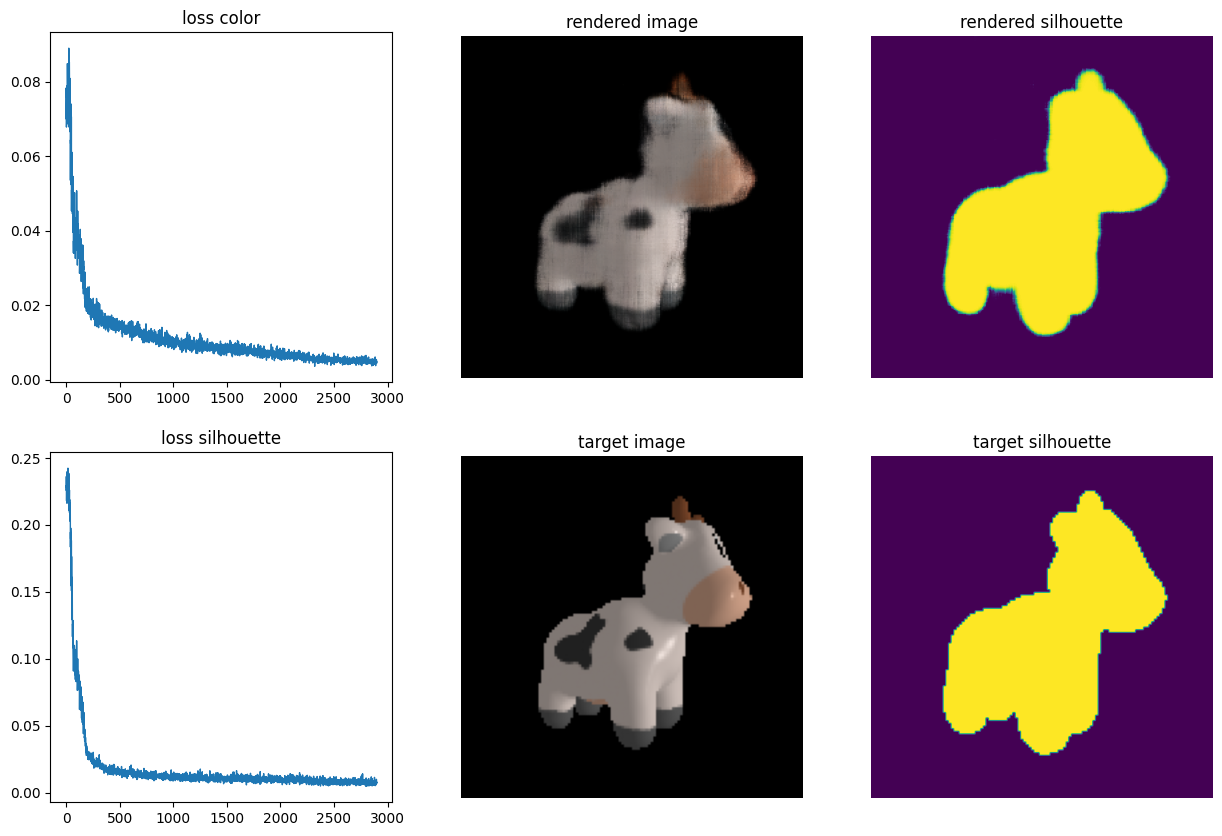

Iteration 02910: loss color = 5.08e-03 loss silhouette = 8.14e-03 PSNR = 27.96 dB
Iteration 02920: loss color = 5.95e-03 loss silhouette = 6.90e-03 PSNR = 26.99 dB
Iteration 02930: loss color = 5.40e-03 loss silhouette = 9.75e-03 PSNR = 27.71 dB
Iteration 02940: loss color = 4.82e-03 loss silhouette = 5.09e-03 PSNR = 28.38 dB
Iteration 02950: loss color = 4.97e-03 loss silhouette = 7.41e-03 PSNR = 27.87 dB
Iteration 02960: loss color = 4.92e-03 loss silhouette = 5.66e-03 PSNR = 28.20 dB
Iteration 02970: loss color = 4.64e-03 loss silhouette = 7.93e-03 PSNR = 28.50 dB
Iteration 02980: loss color = 4.22e-03 loss silhouette = 4.89e-03 PSNR = 28.98 dB
Iteration 02990: loss color = 4.52e-03 loss silhouette = 5.34e-03 PSNR = 28.79 dB


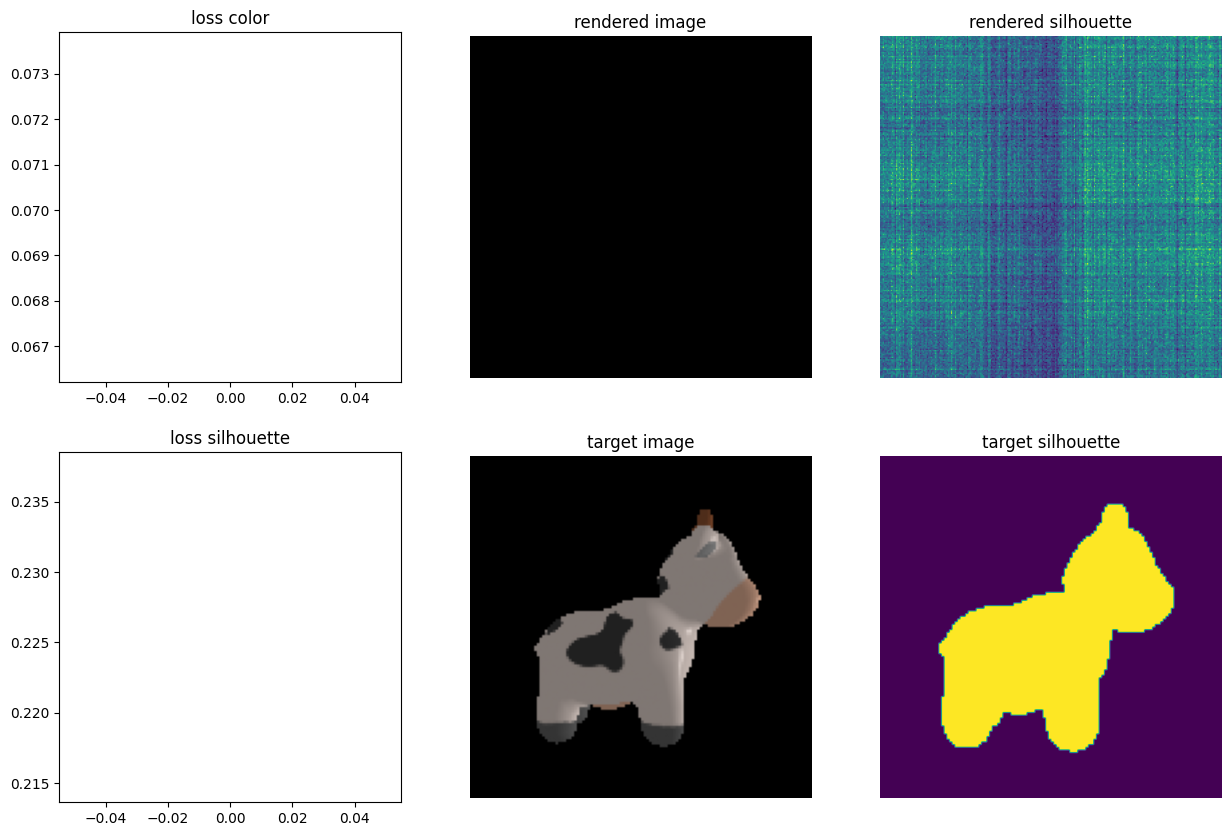

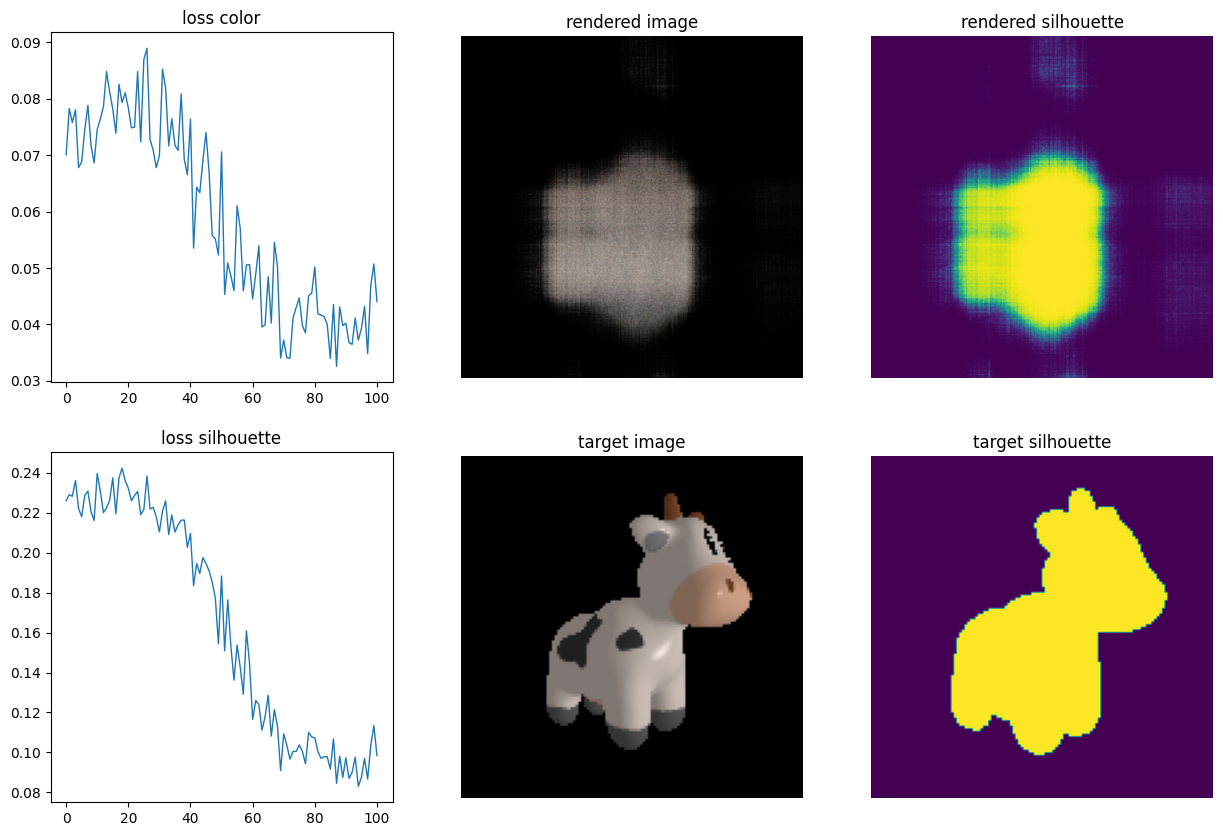

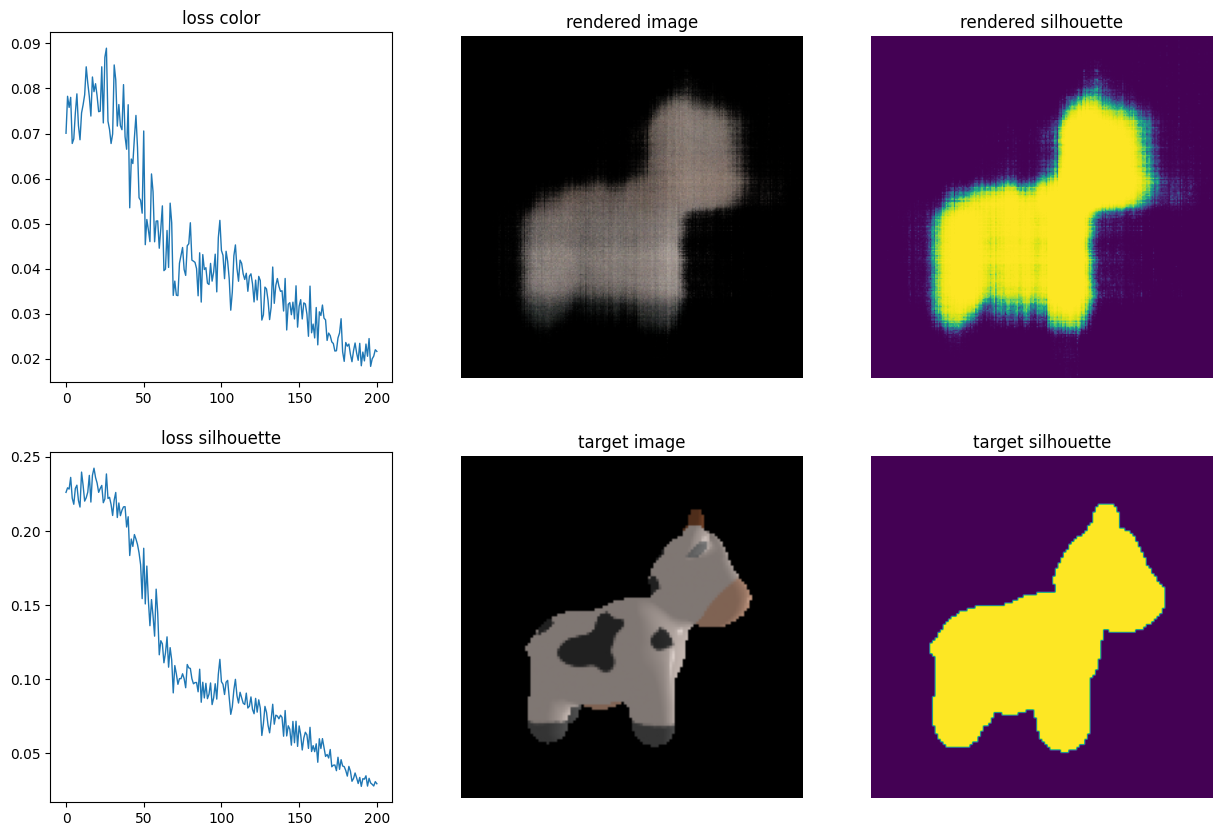

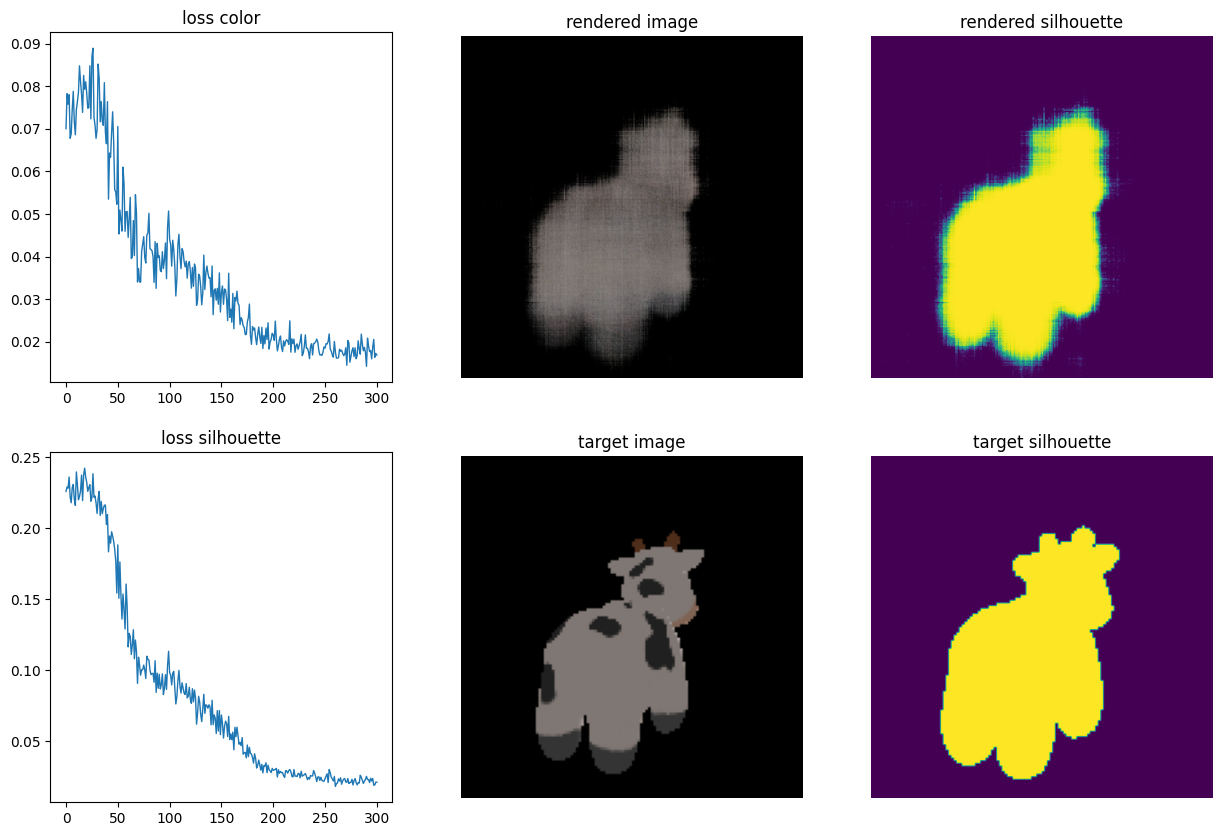

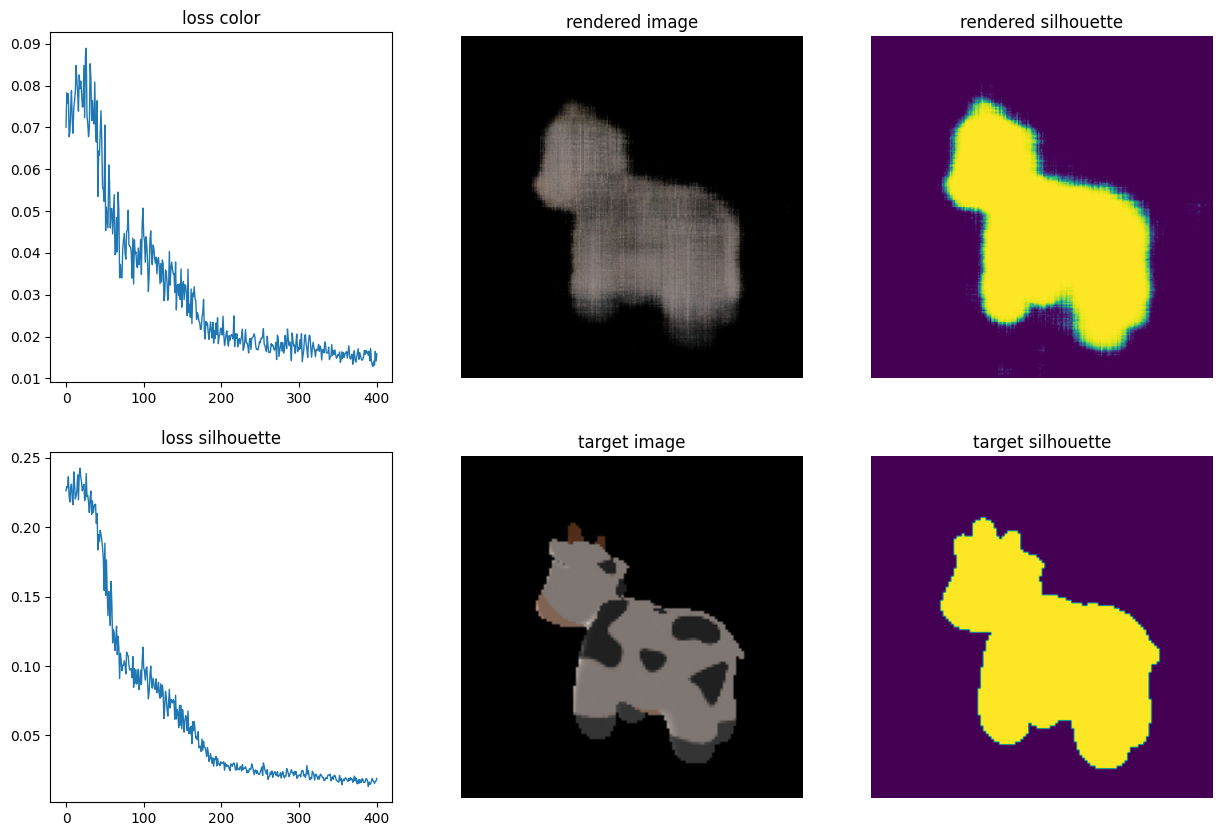

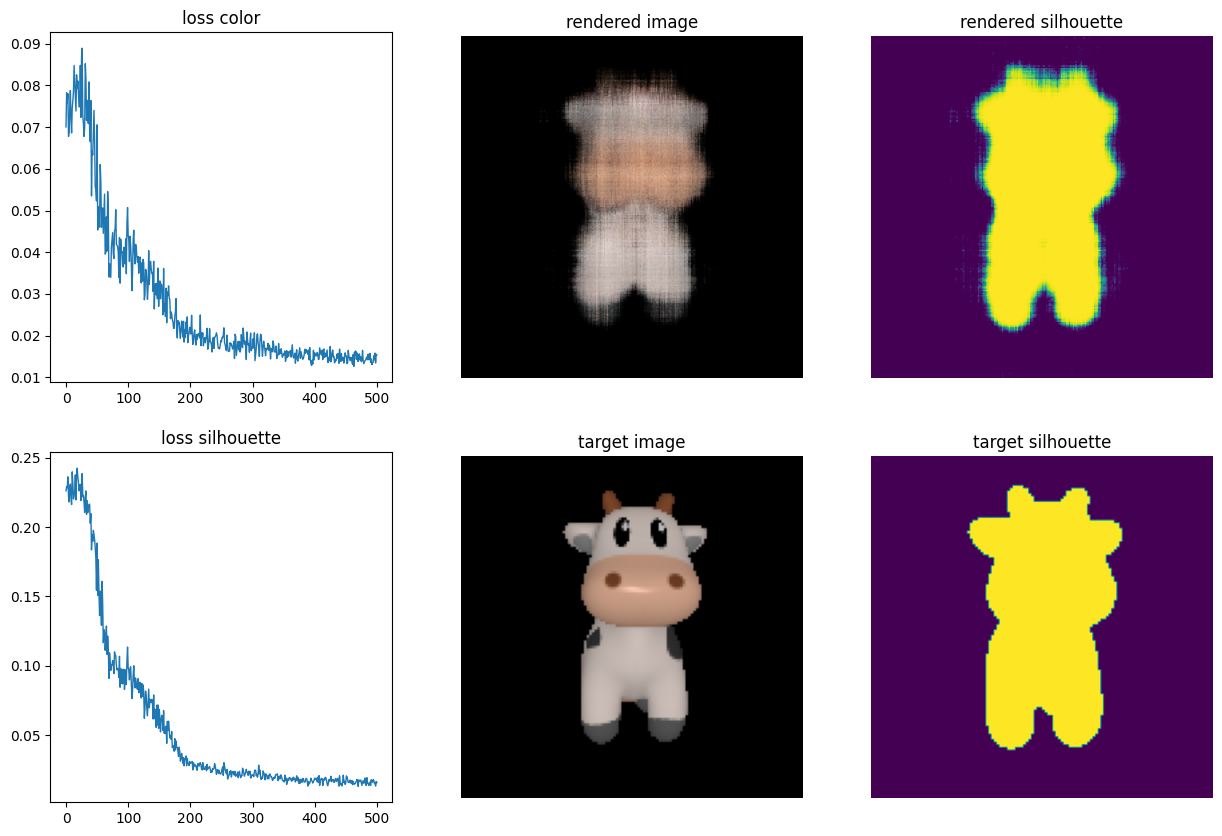

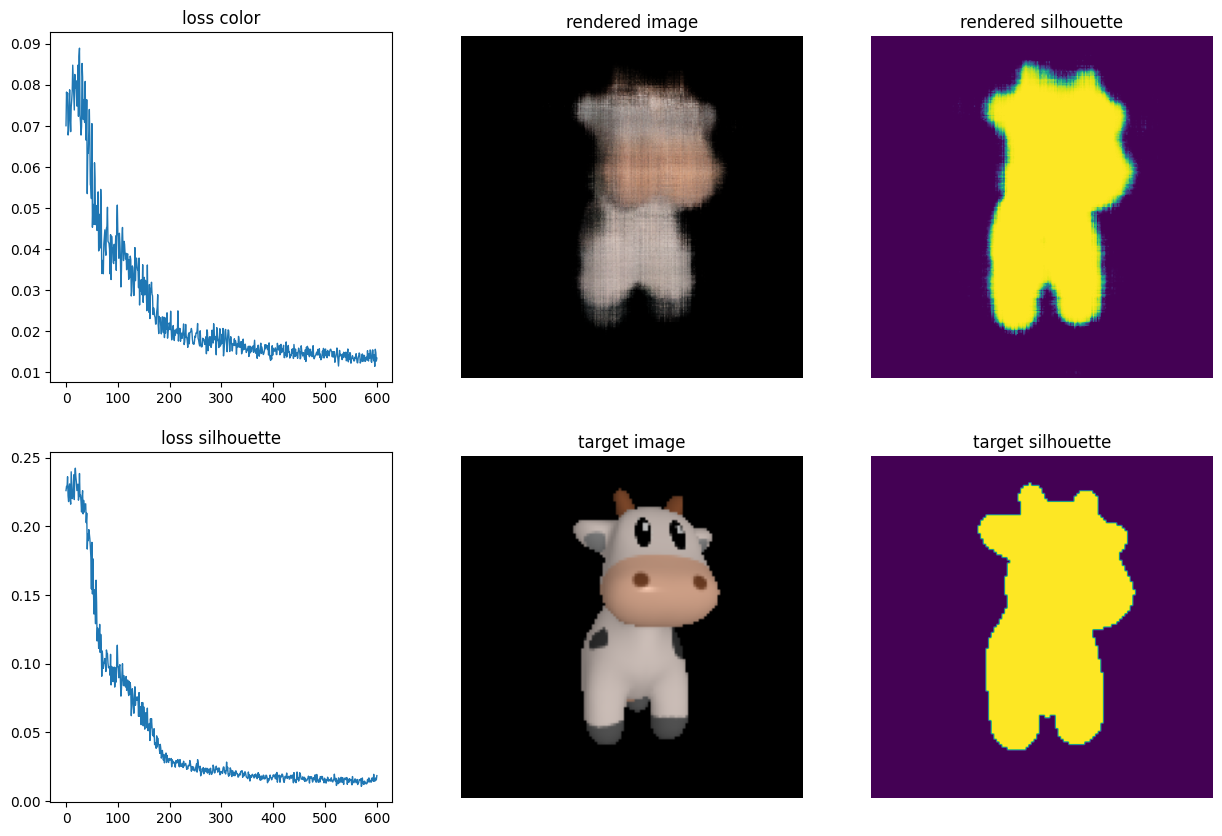

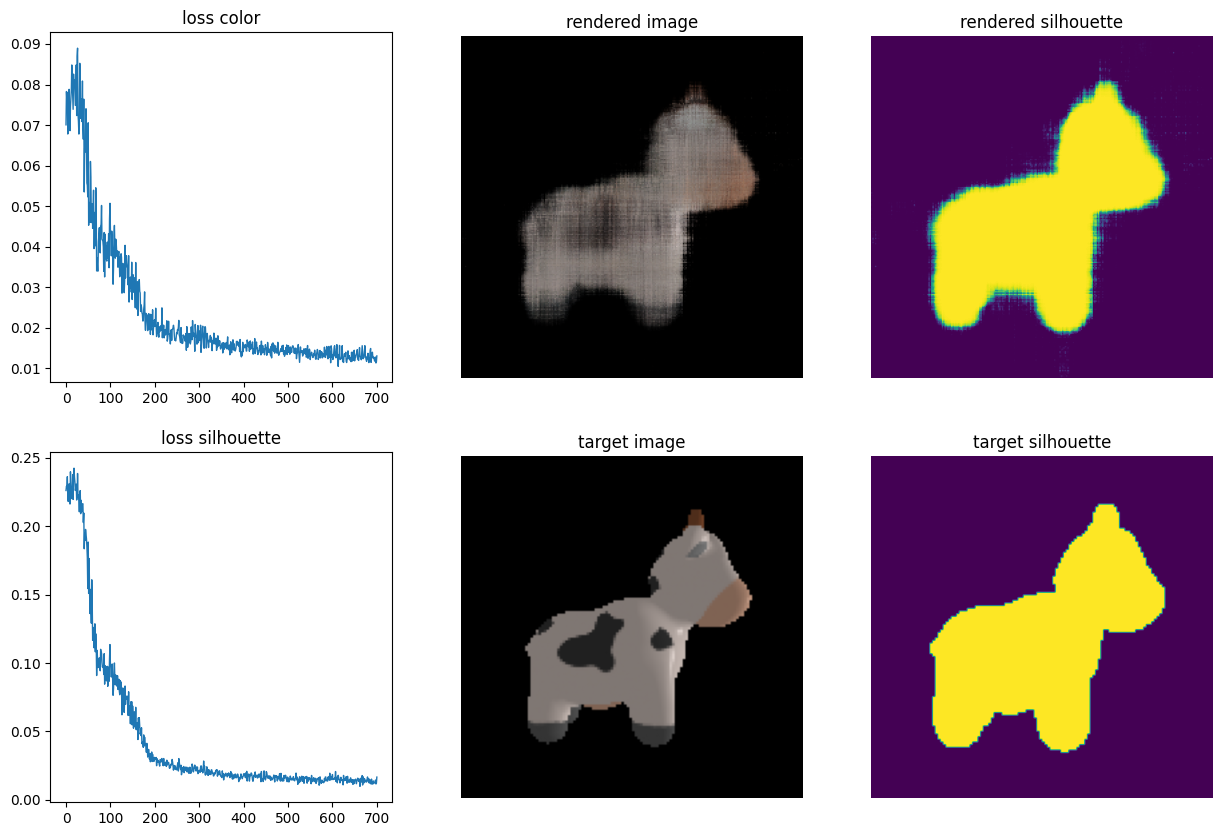

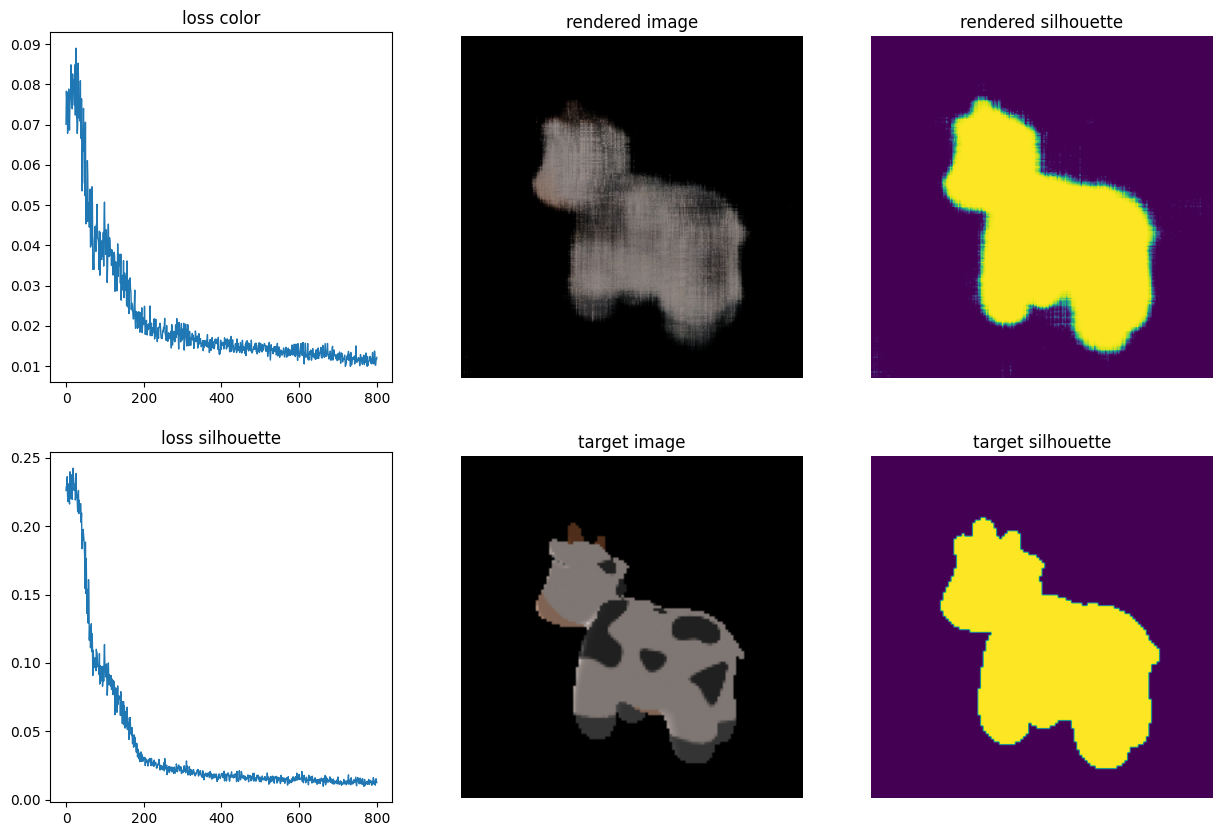

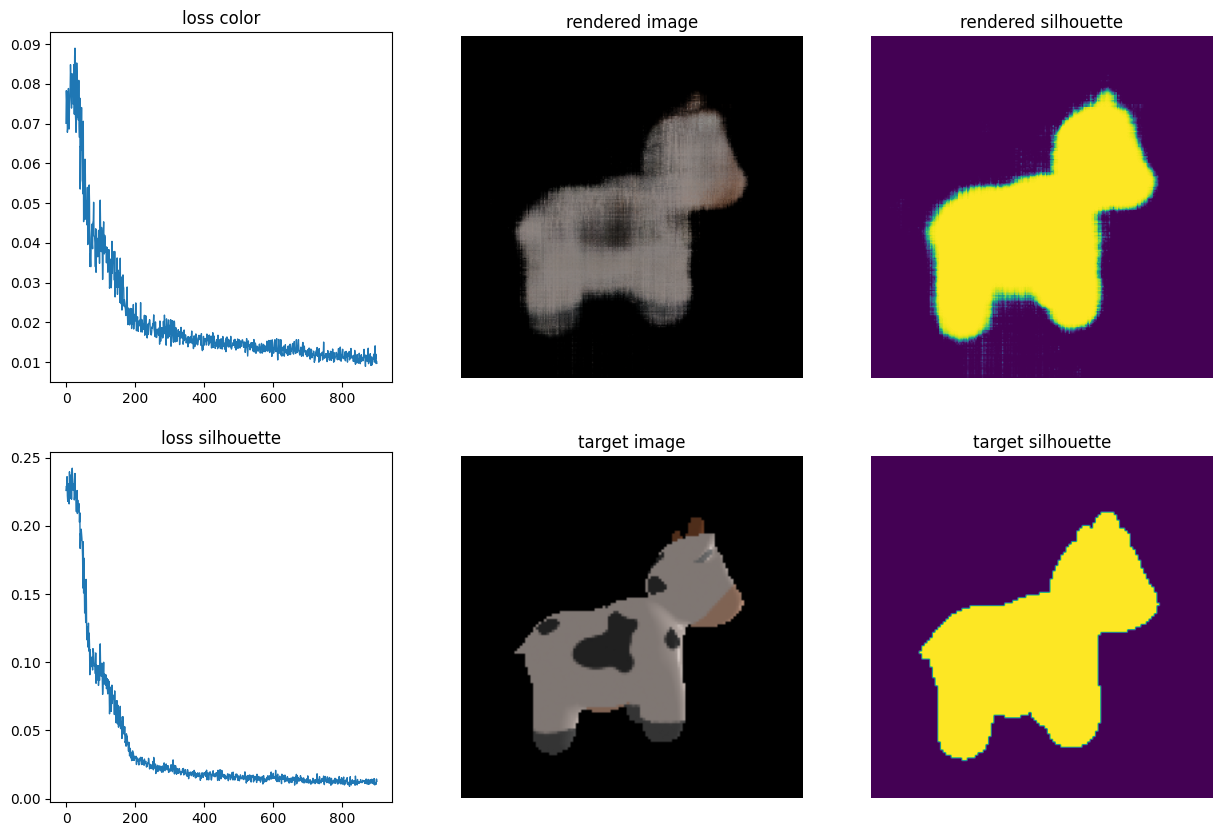

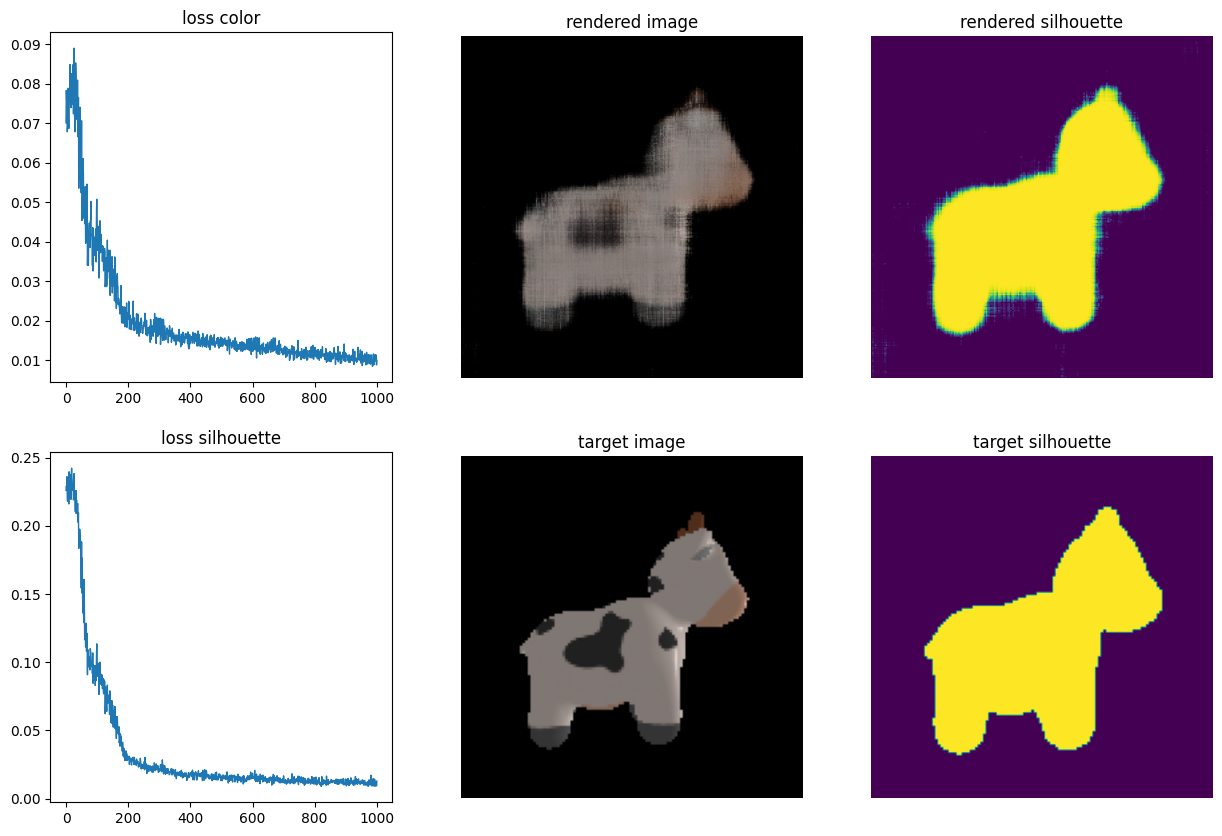

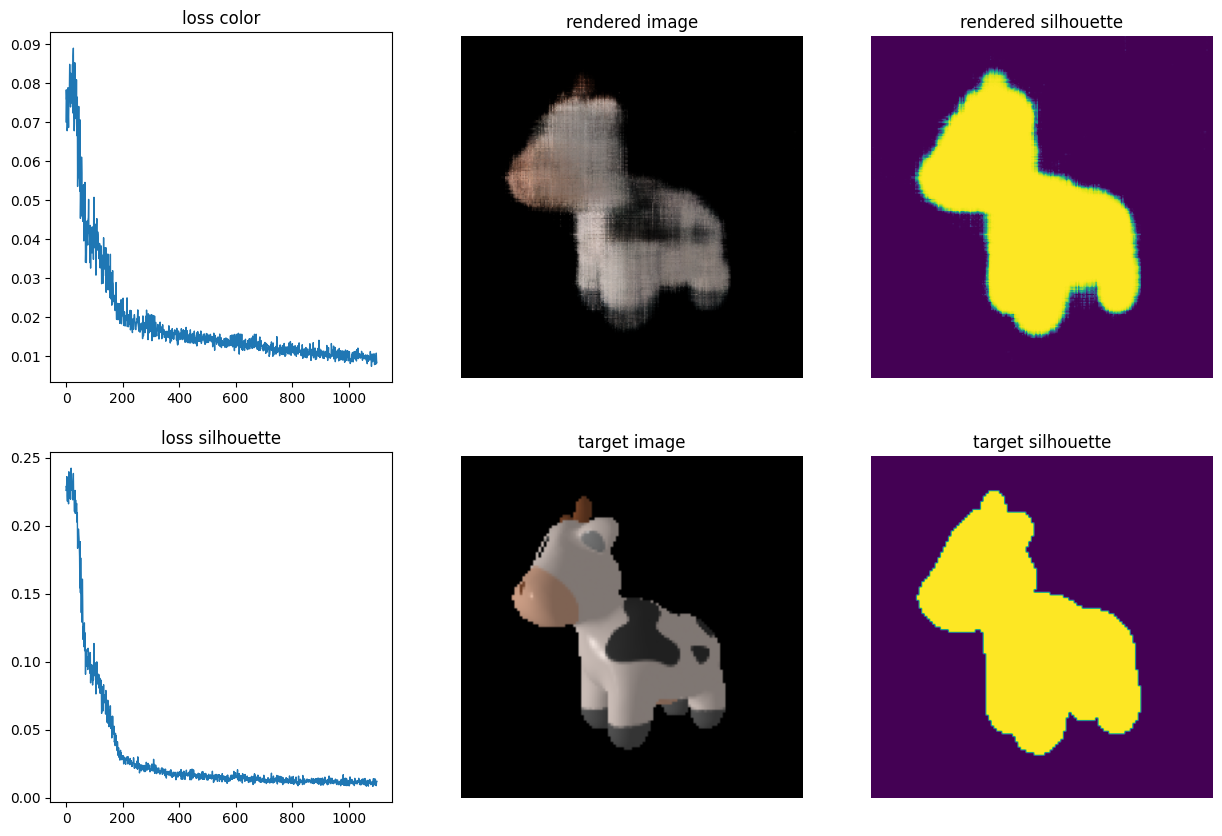

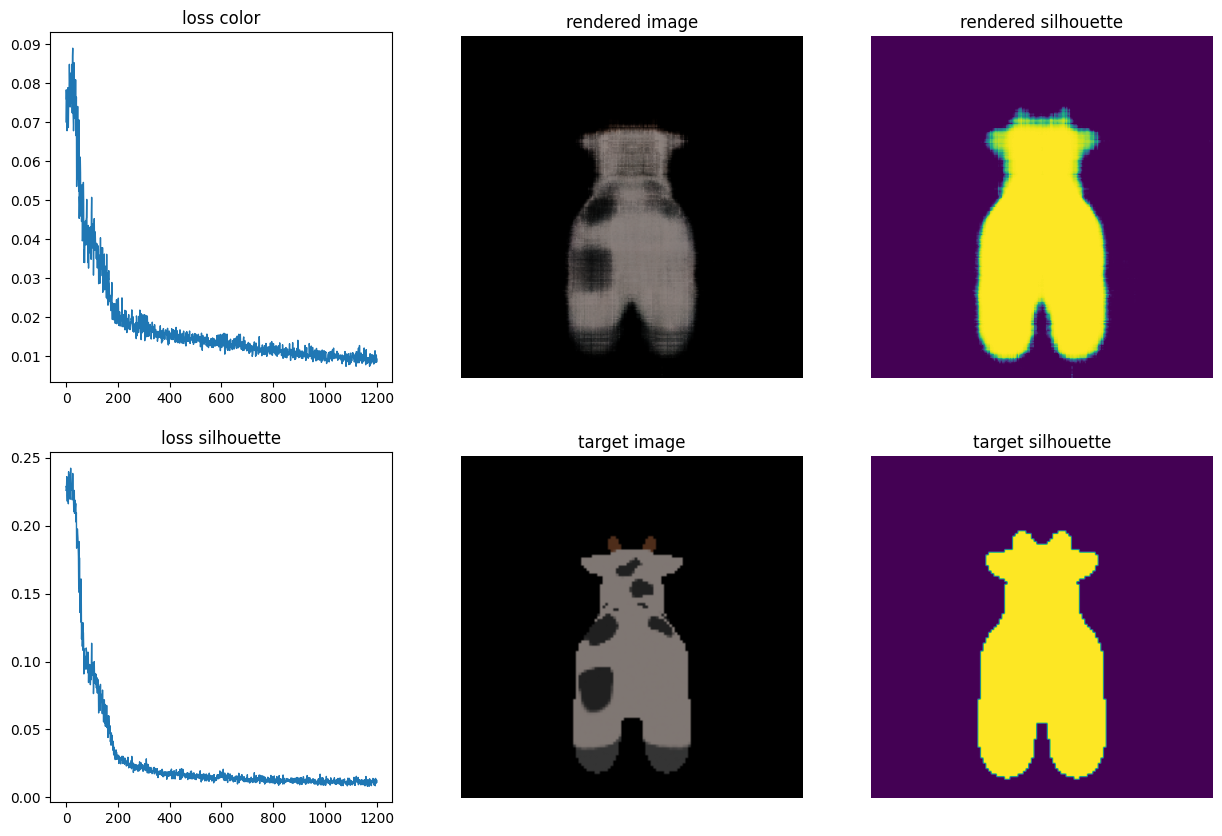

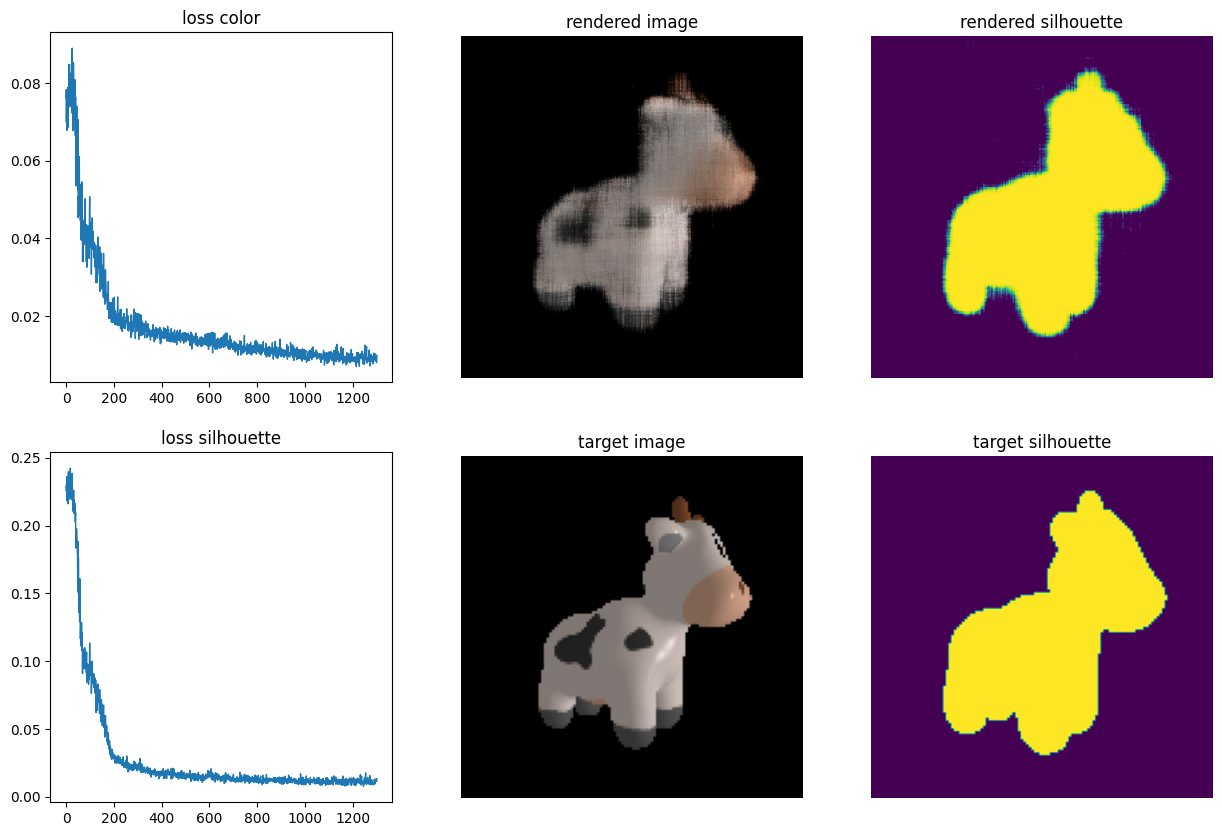

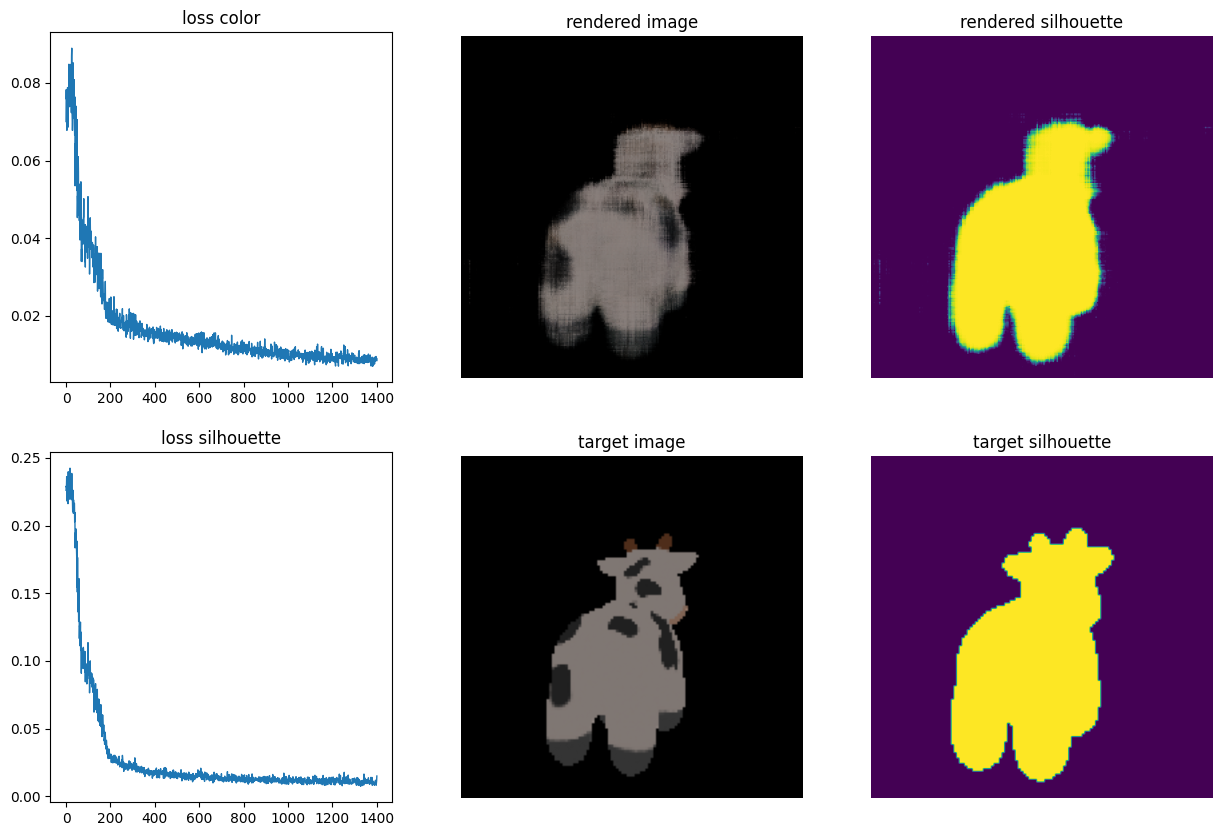

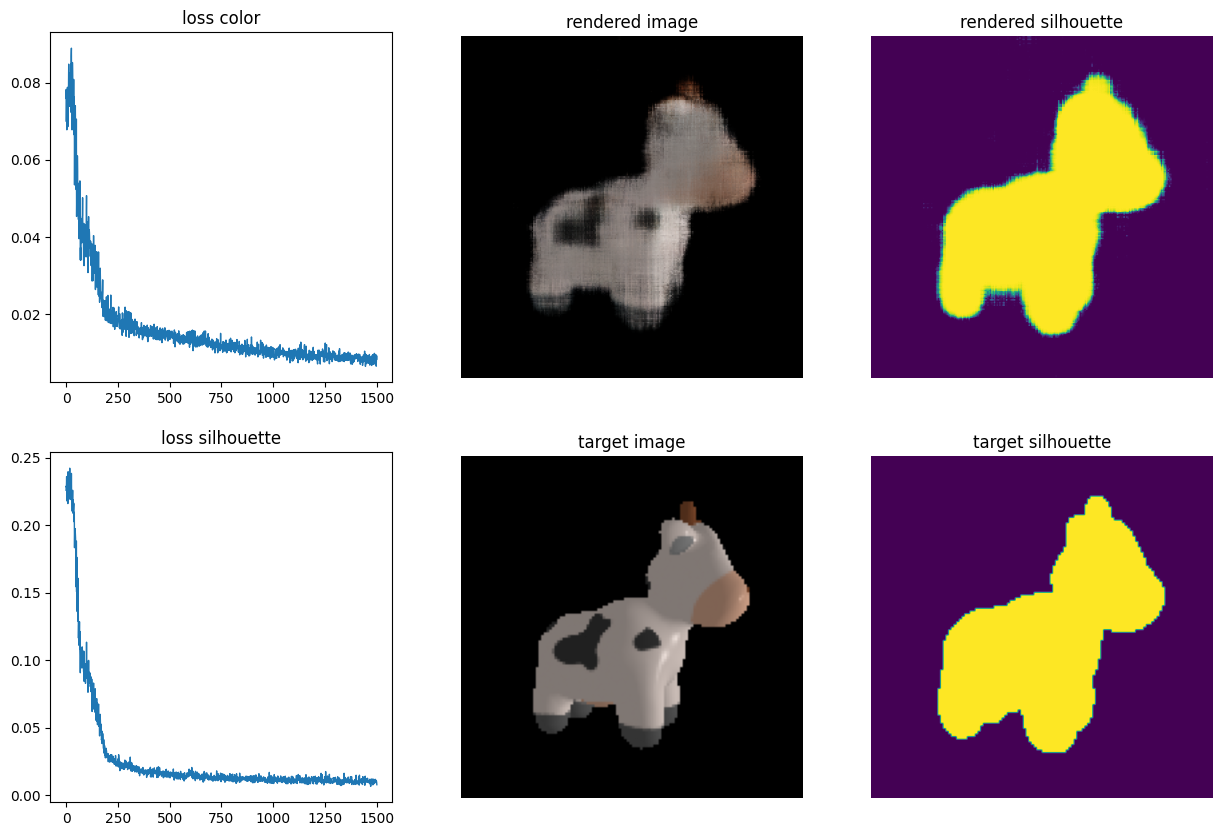

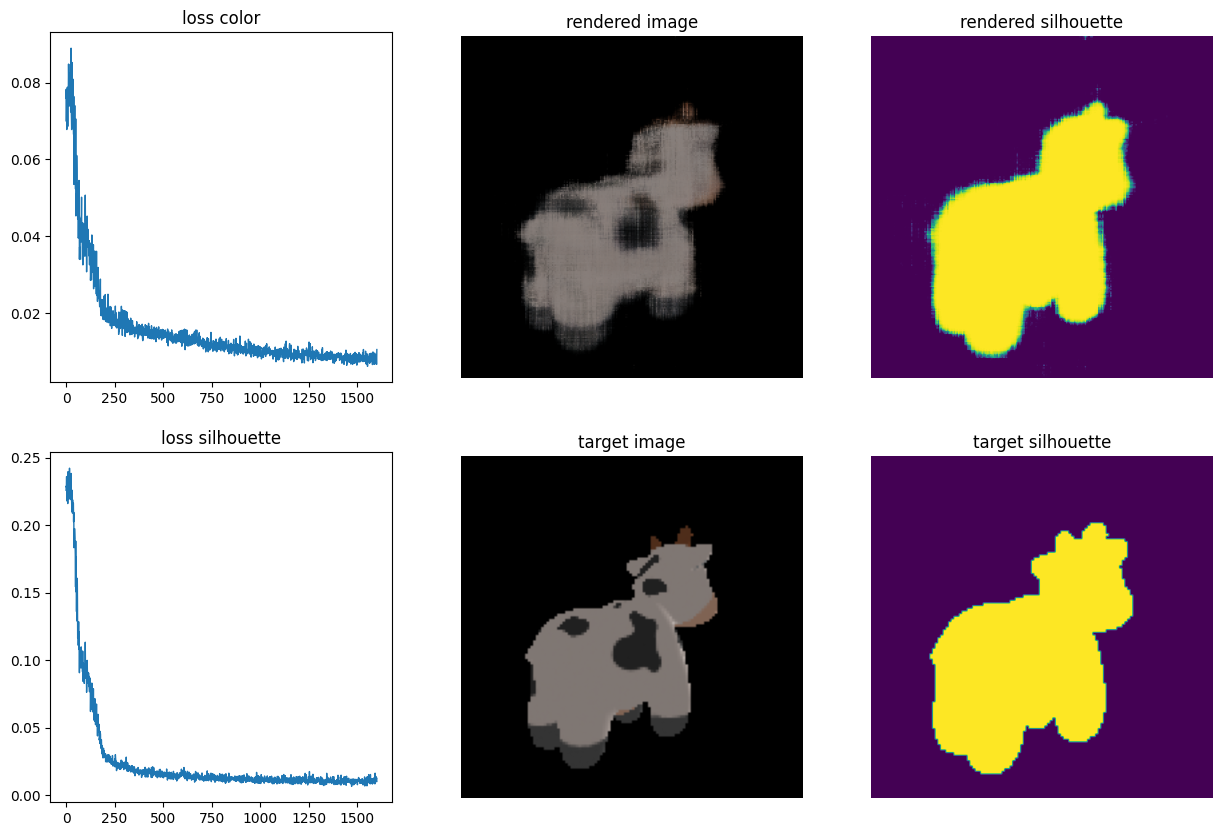

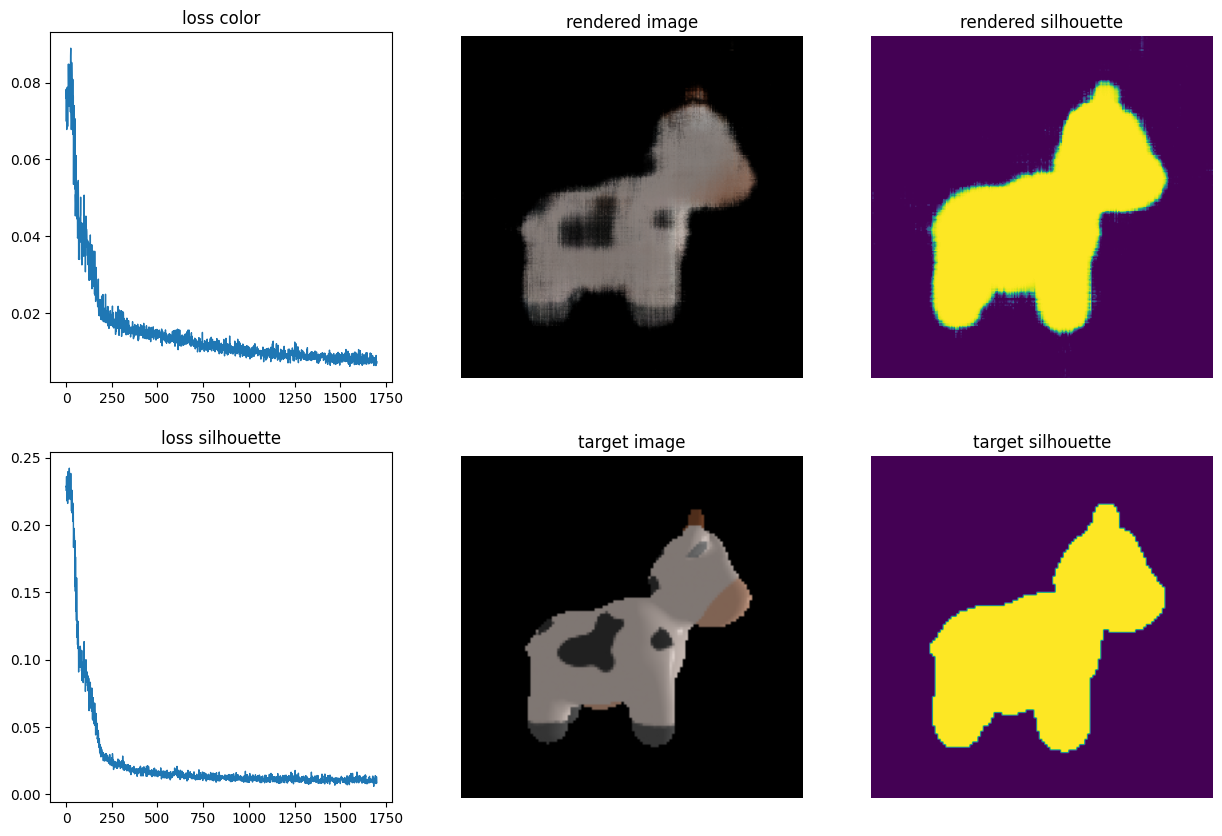

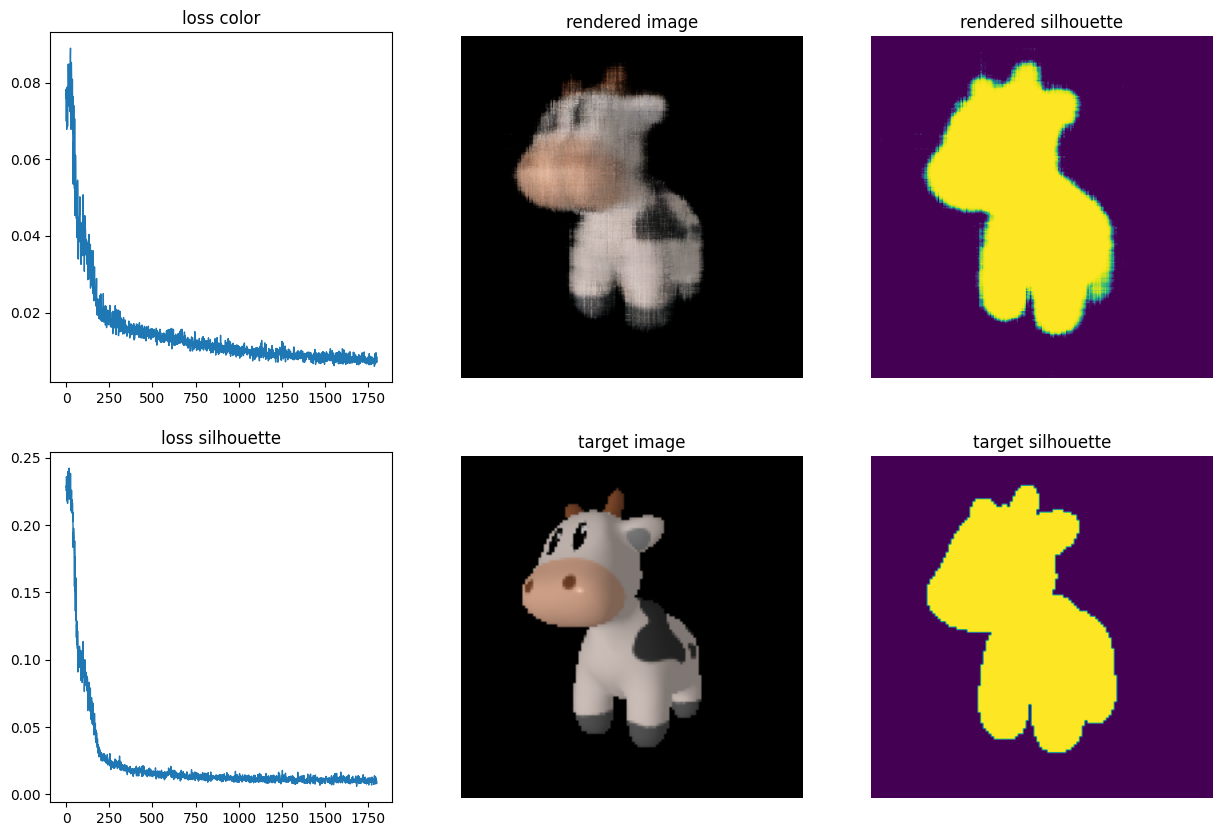

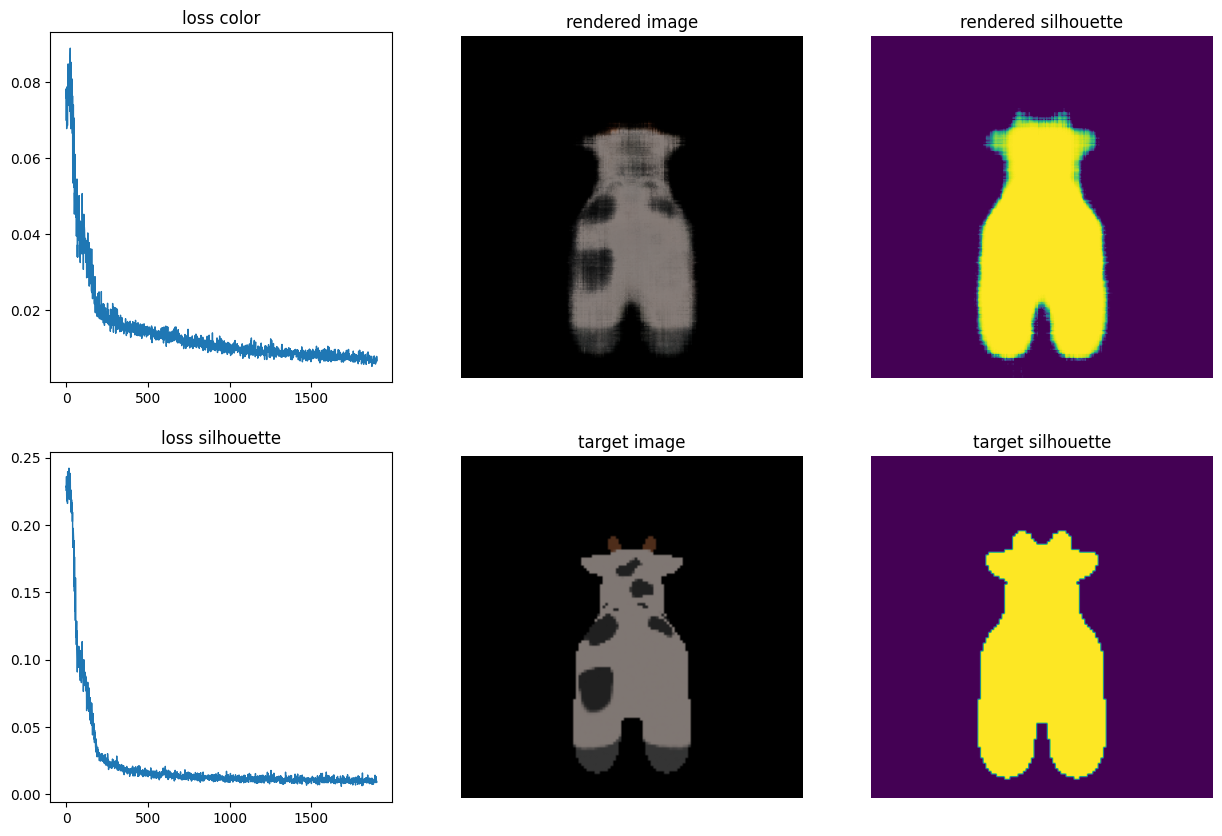

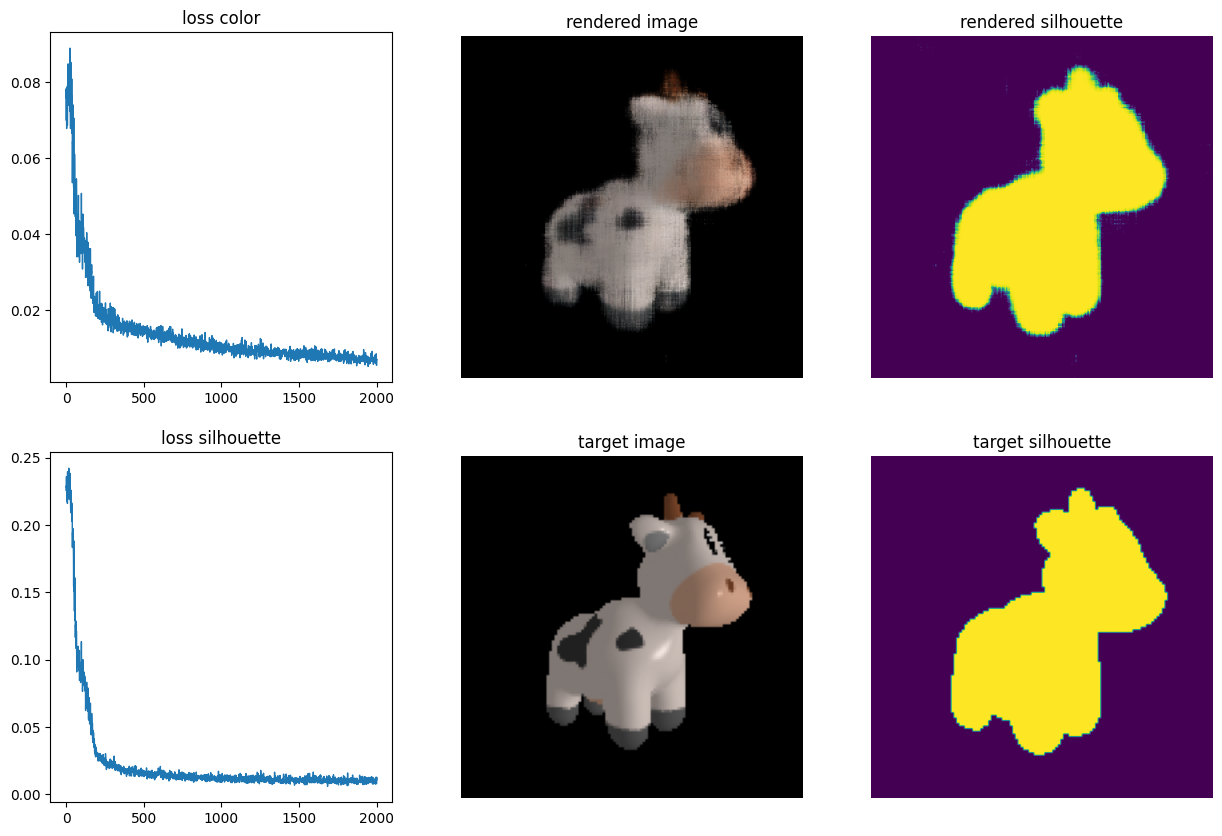

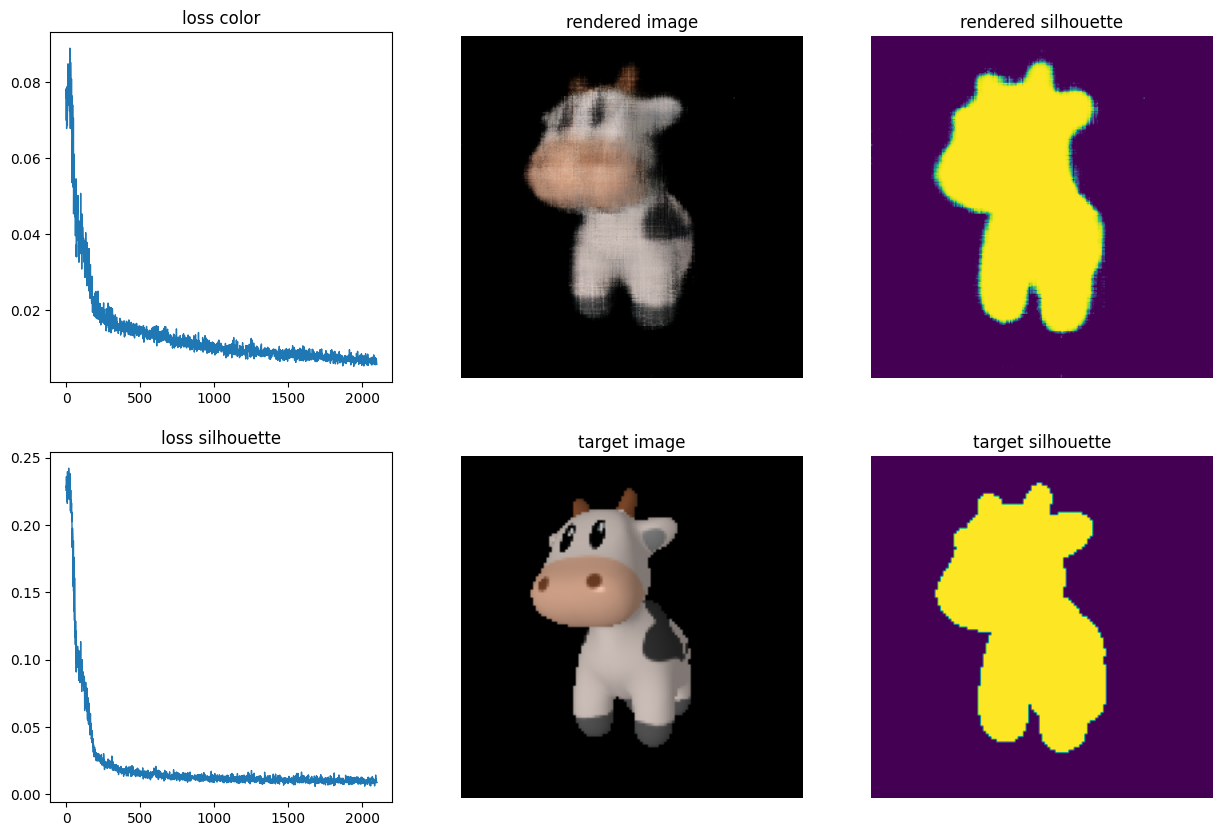

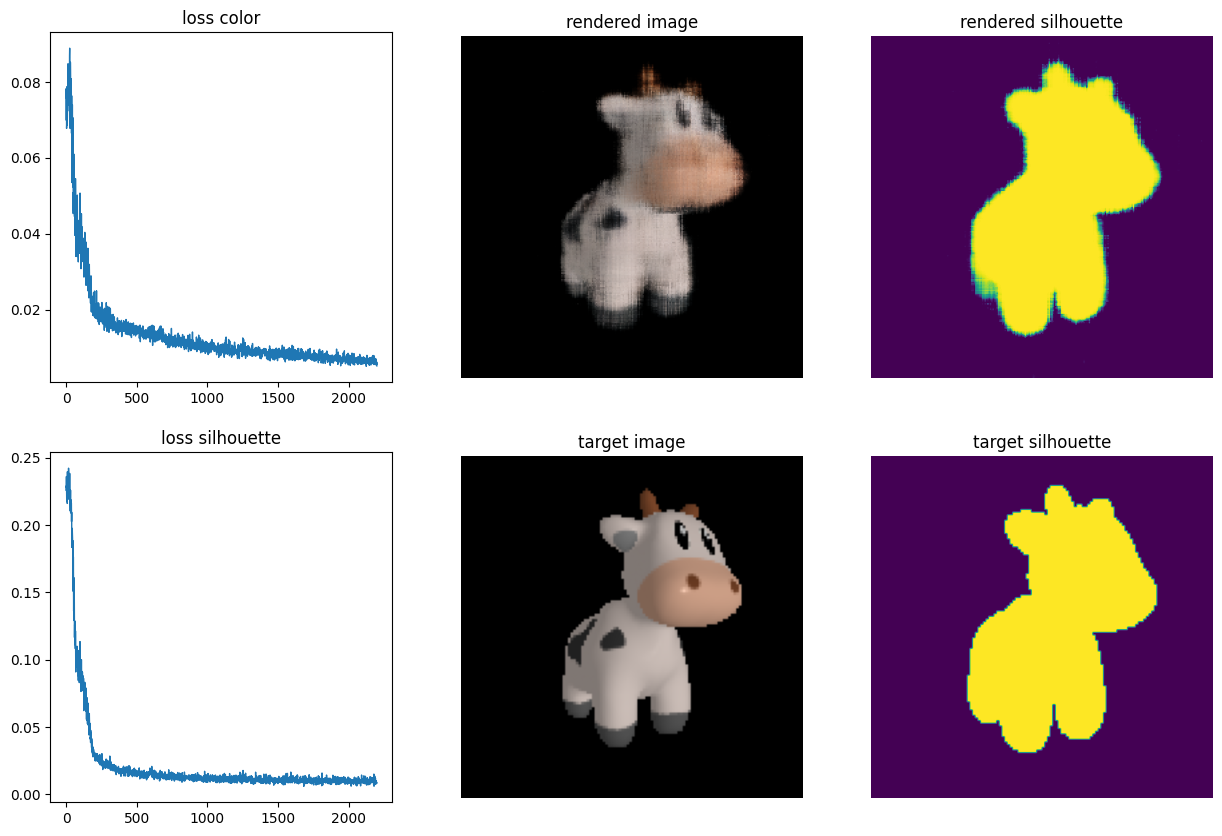

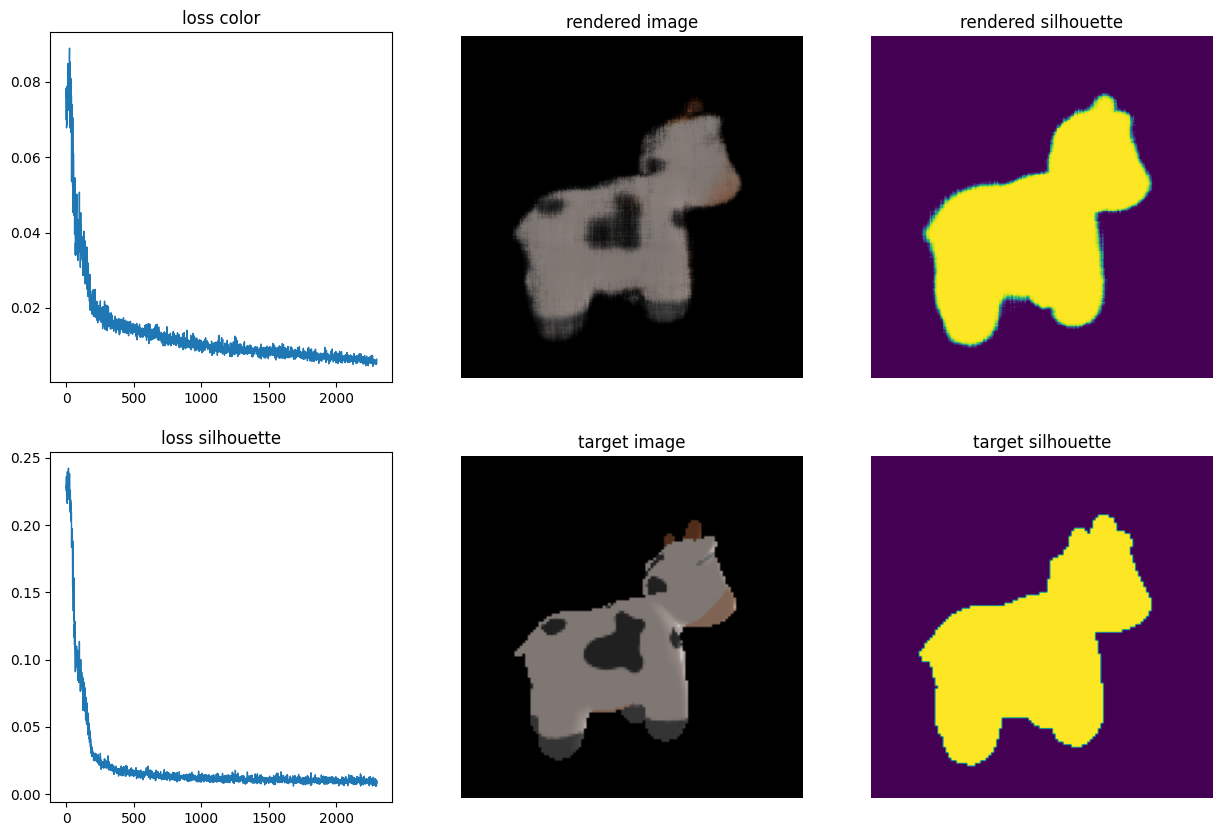

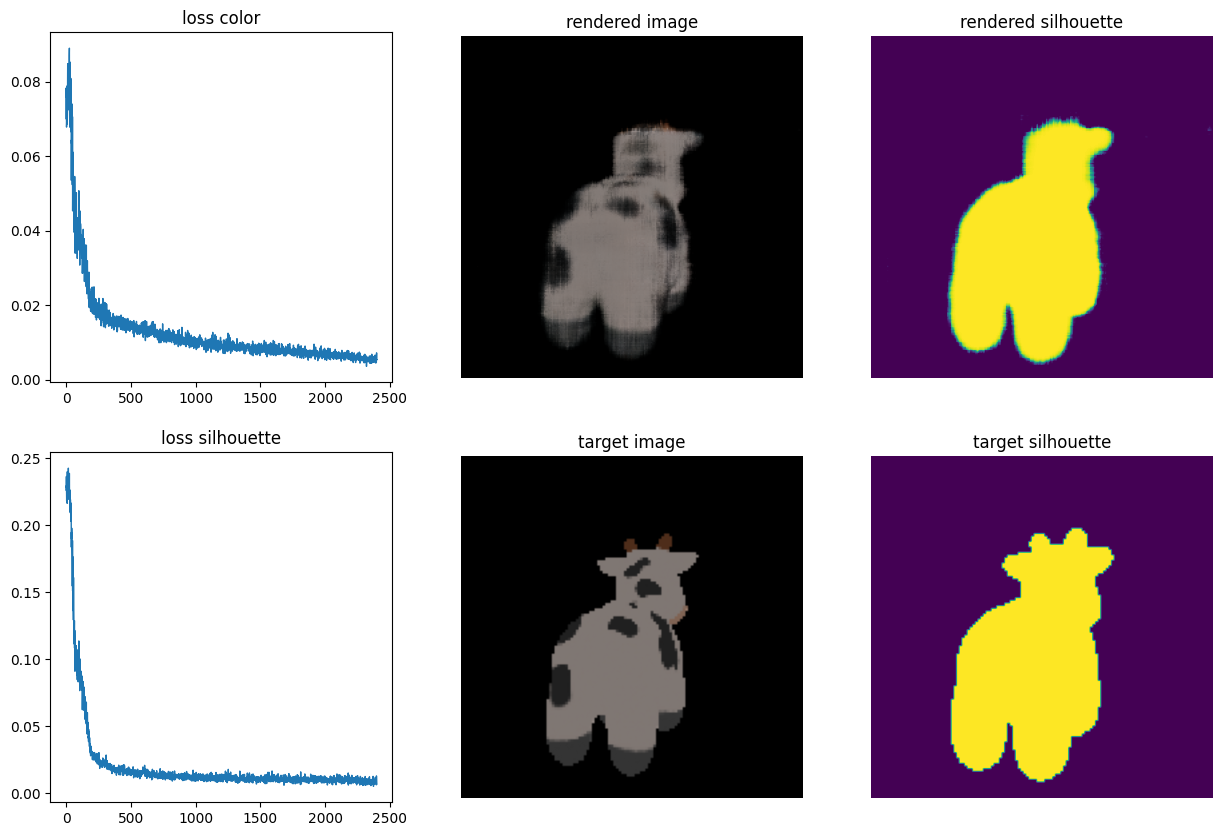

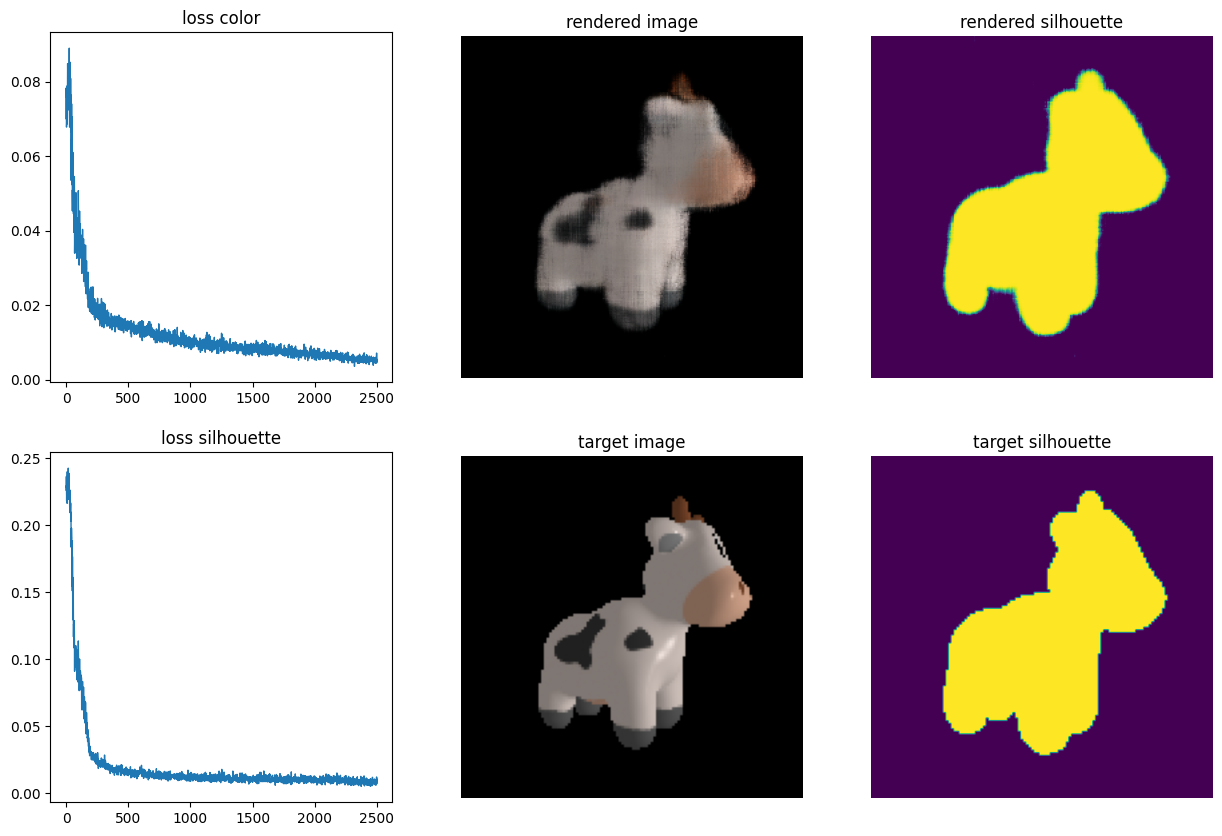

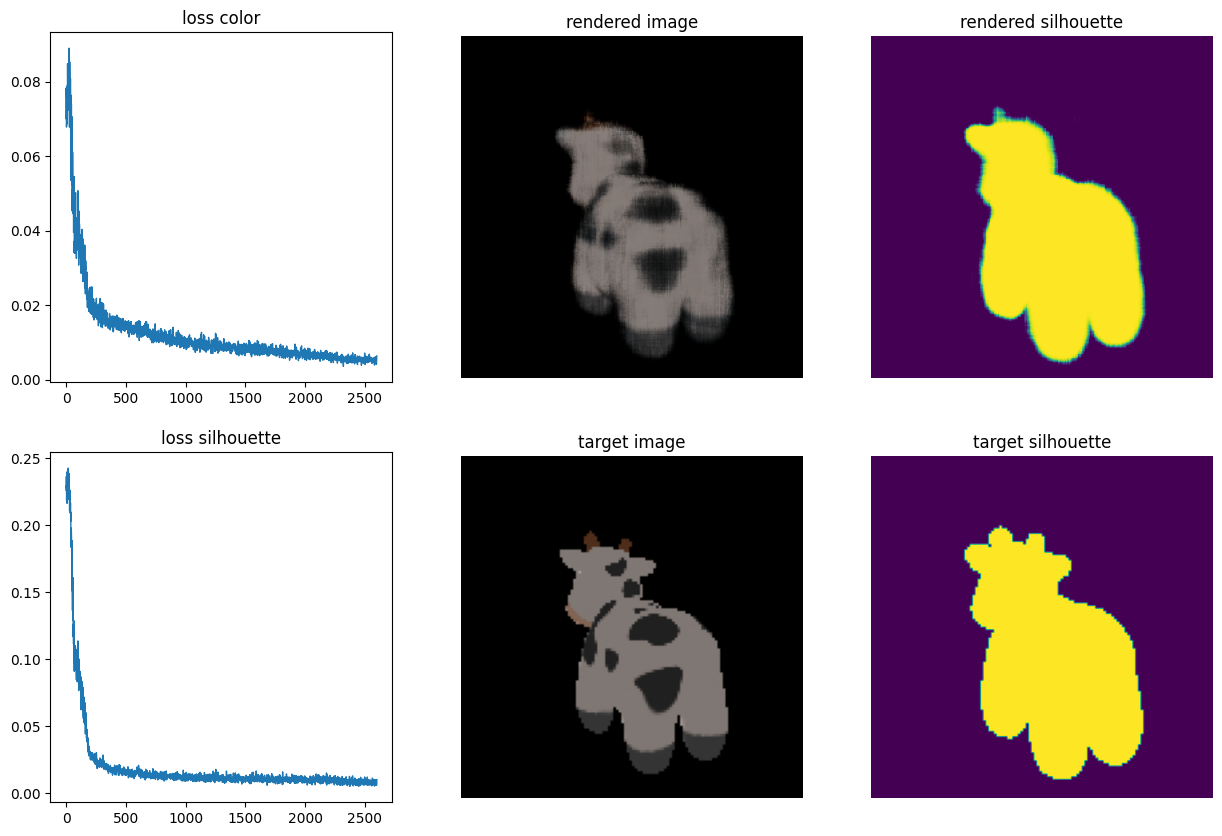

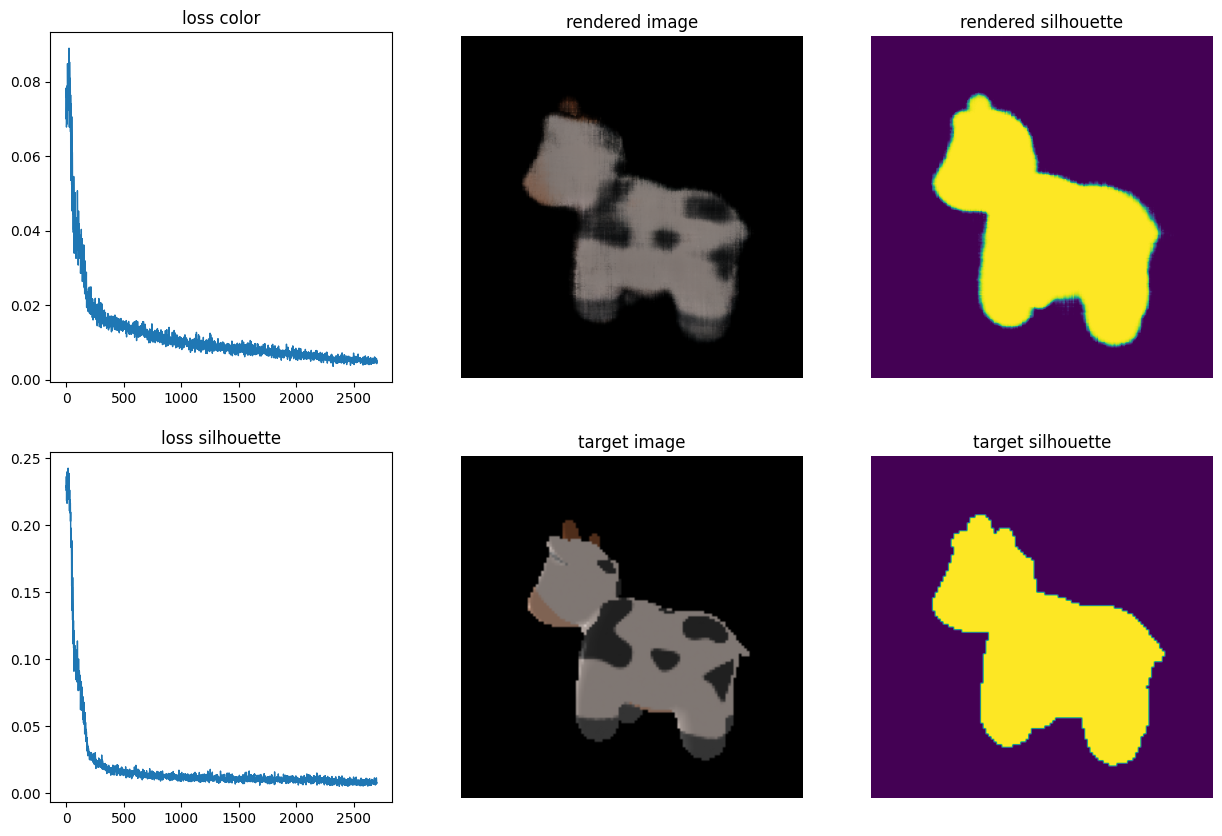

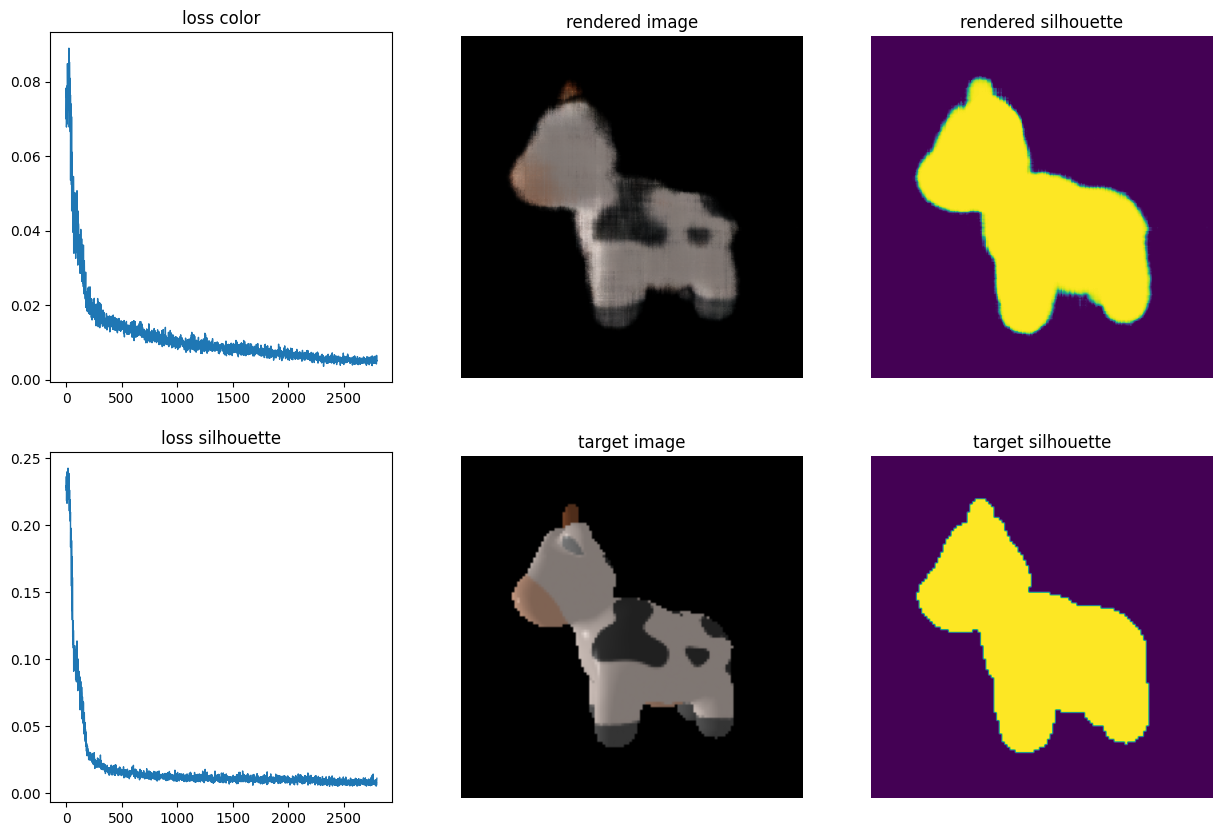

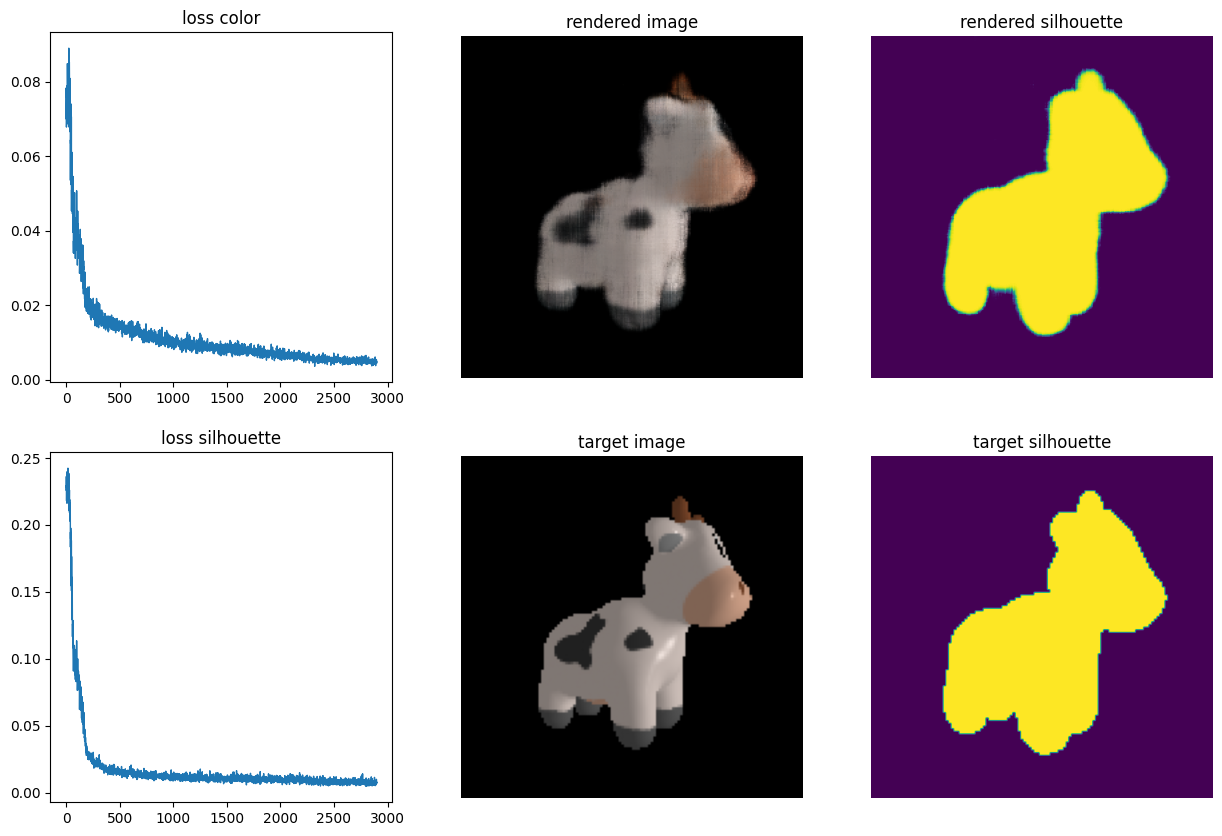

In [ ]:
# PSNR computation function
def compute_psnr(predicted_image, target_image, max_pixel_value=1.0):
    mse = F.mse_loss(predicted_image, target_image)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr

# Ensure all relevant variables are on the correct device
renderer_grid = renderer_grid.to(device)
renderer_mc = renderer_mc.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Set the seed for reproducibility
torch.manual_seed(1)

# Instantiate the radiance field model and optimizer
neural_radiance_field = NeuralRadianceField().to(device)
lr = 1e-3
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)

# Parameters for the optimization loop
batch_size = 6
n_iter = 3000
loss_history_color, loss_history_sil = [], []
psnr_history = []  # PSNR history buffer

# Adaptive sampling function for dynamically adjusting points per ray
def adaptive_ray_sampling(silhouette, threshold=0.1):

    # Simple logic: if silhouette is mostly background, reduce n_pts_per_ray
    if silhouette.mean() < threshold:
        return n_pts_per_ray_bg  # Use fewer points for background areas
    return n_pts_per_ray_main   # Use standard points for foreground


# Main optimization loop
for iteration in range(n_iter):
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr * 0.1)

    optimizer.zero_grad()
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras
    batch_cameras = FoVPerspectiveCameras(
        R=target_cameras.R[batch_idx],
        T=target_cameras.T[batch_idx],
        znear=target_cameras.znear[batch_idx],
        zfar=target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov=target_cameras.fov[batch_idx],
        device=device,
    )

    batch_silhouettes = target_silhouettes[batch_idx]

    # Dynamically set n_pts_per_ray based on silhouette content
    n_pts_per_ray_adapted = adaptive_ray_sampling(batch_silhouettes)
    raysampler_mc.n_pts_per_ray = n_pts_per_ray_adapted

    # Evaluate the nerf model
    rendered_images_silhouettes, sampled_rays = renderer_mc(
        cameras=batch_cameras,
        volumetric_function=neural_radiance_field
    )
    rendered_images, rendered_silhouettes = rendered_images_silhouettes.split([3, 1], dim=-1)

    # Compute silhouette error as mean huber loss between predicted and target silhouettes
    silhouettes_at_rays = sample_images_at_mc_locs(
        target_silhouettes[batch_idx, ..., None],
        sampled_rays.xys
    )
    sil_err = huber(rendered_silhouettes, silhouettes_at_rays).abs().mean()

    # Compute color error as mean huber loss between rendered and target images
    colors_at_rays = sample_images_at_mc_locs(
        target_images[batch_idx],
        sampled_rays.xys
    )
    color_err = huber(rendered_images, colors_at_rays).abs().mean()

    # Compute PSNR between the rendered and target images
    psnr = compute_psnr(rendered_images, colors_at_rays)
    psnr_history.append(float(psnr))  # Log PSNR for later analysis

    # Total optimization loss as a sum of color and silhouette errors
    loss = color_err + sil_err
    loss_history_color.append(float(color_err))
    loss_history_sil.append(float(sil_err))

    # Log losses and PSNR every 10 iterations
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' loss color = {float(color_err):1.2e}'
            + f' loss silhouette = {float(sil_err):1.2e}'
            + f' PSNR = {float(psnr):1.2f} dB'
        )

    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()

    # Visualization every 100 iterations
    if iteration % 100 == 0:
        show_idx = torch.randperm(len(target_cameras))[:1]
        show_full_render(
            neural_radiance_field,
            FoVPerspectiveCameras(
                R=target_cameras.R[show_idx],
                T=target_cameras.T[show_idx],
                znear=target_cameras.znear[show_idx],
                zfar=target_cameras.zfar[show_idx],
                aspect_ratio=target_cameras.aspect_ratio[show_idx],
                fov=target_cameras.fov[show_idx],
                device=device,
            ),
            target_images[show_idx][0],
            target_silhouettes[show_idx][0],
            loss_history_color,
            loss_history_sil,
            # psnr_history  # Optionally visualize the PSNR history too
        )


Rendering rotating NeRF ...


  0%|          | 0/15 [00:00<?, ?it/s]

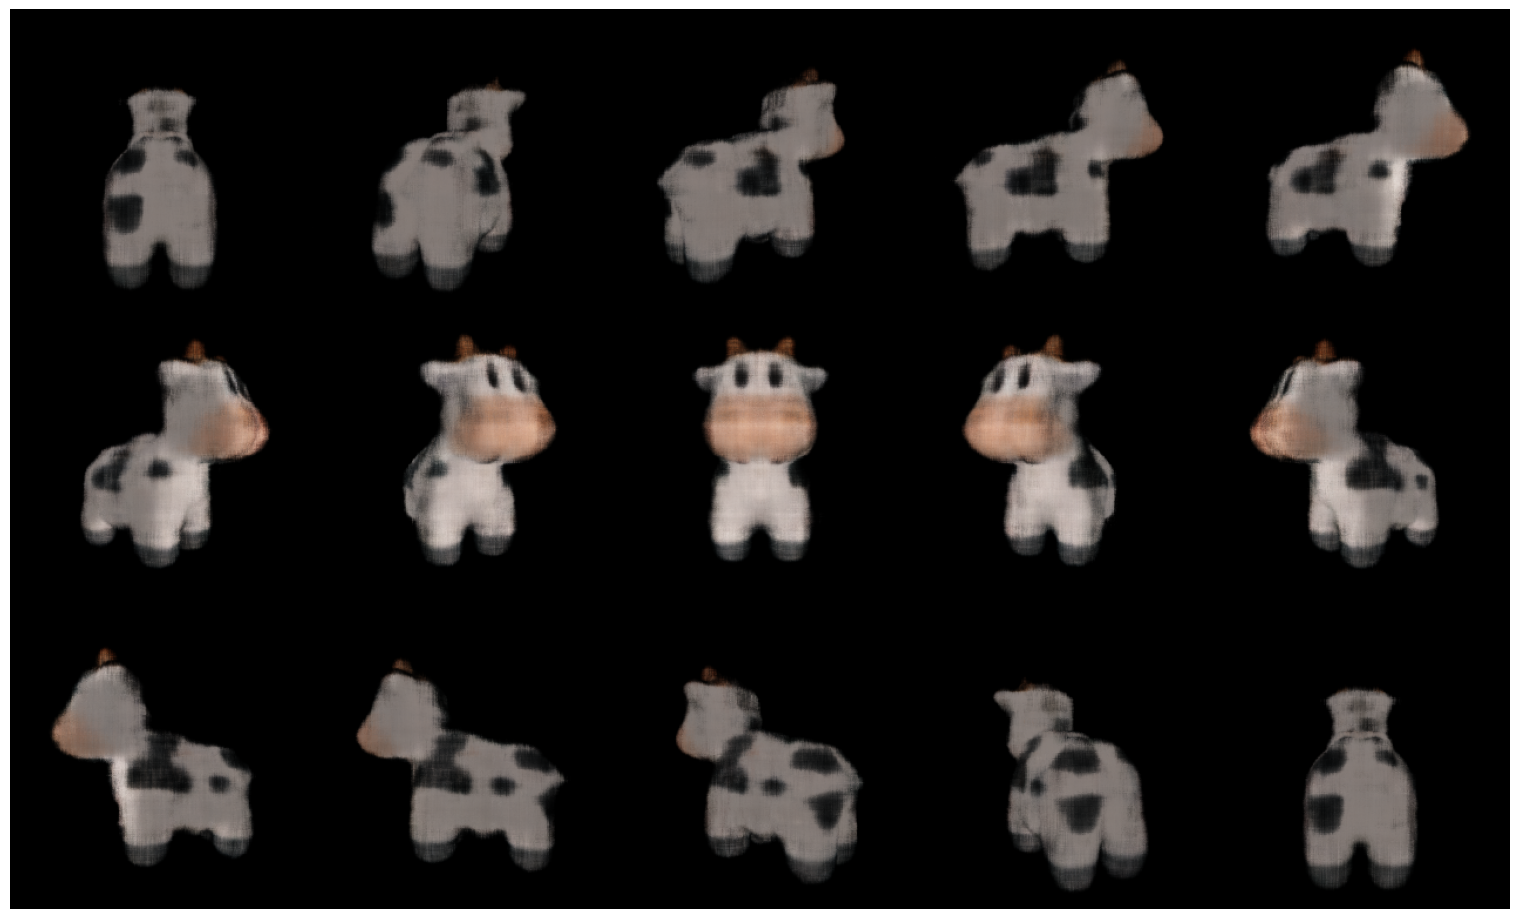

In [ ]:
def generate_rotating_nerf(neural_radiance_field, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Rendering rotating NeRF ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        # Note that we again render with `NDCMultinomialRaysampler`
        # and the batched_forward function of neural_radiance_field.
        frames.append(
            renderer_grid(
                cameras=camera,
                volumetric_function=neural_radiance_field.batched_forward,
            )[0][..., :3]
        )
    return torch.cat(frames)

with torch.no_grad():
    rotating_nerf_frames = generate_rotating_nerf(neural_radiance_field, n_frames=3*5)

image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

In [ ]:
#

#del optimizer
#torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn.functional as F

def compute_ssim(img1, img2, window_size=11, sigma=1.5, max_pixel_value=1.0):
    """Computes SSIM between two images (img1 and img2) with a Gaussian kernel."""

    def gaussian_window(window_size, sigma):
        coords = torch.arange(window_size, dtype=torch.float32) - window_size // 2
        grid = coords.unsqueeze(0).expand(window_size, window_size) ** 2
        window = torch.exp(-grid / (2 * sigma ** 2))
        return (window / window.sum()).view(1, 1, window_size, window_size)

    window = gaussian_window(window_size, sigma).to(img1.device)

    if img1.size(1) > 1:
        img1 = img1[:, :3].mean(dim=1, keepdim=True)  # Convert to grayscale
        img2 = img2[:, :3].mean(dim=1, keepdim=True)

    if img1.dim() < 4:
        img1 = img1.unsqueeze(1)
    if img2.dim() < 4:
        img2 = img2.unsqueeze(1)

    mu1 = F.conv2d(img1, window, padding=window_size // 2)
    mu2 = F.conv2d(img2, window, padding=window_size // 2)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2) - mu1_mu2

    C1 = (0.01 * max_pixel_value) ** 2
    C2 = (0.03 * max_pixel_value) ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


import torch.nn.functional as F

# Render the final image
with torch.no_grad():
    final_camera = FoVPerspectiveCameras(
        R=target_cameras.R[0:1],  # Get the rotation matrix for the first camera
        T=target_cameras.T[0:1],  # Get the translation vector for the first camera
        znear=target_cameras.znear[0:1],
        zfar=target_cameras.zfar[0:1],
        aspect_ratio=target_cameras.aspect_ratio[0:1],
        fov=target_cameras.fov[0:1],
        device=device
    )
    final_rendered_image, _ = renderer_grid(
        cameras=final_camera,
        volumetric_function=neural_radiance_field.batched_forward
    )
    final_target_image = target_images[0:1]

    # Resize the target image to match the rendered image's dimensions
    final_target_image_resized = F.interpolate(
        final_target_image.permute(0, 3, 1, 2),  # Convert to BxCxHxW format
        size=(final_rendered_image.shape[1], final_rendered_image.shape[2]),  # Match height and width
        mode='bilinear',
        align_corners=False
    ).permute(0, 2, 3, 1)  # Convert back to BxHxWxC format if needed

    # Compute SSIM on the final rendered and resized target images
    ssim_value = compute_ssim(
        final_rendered_image.permute(0, 3, 1, 2),  # Convert to BxCxHxW
        final_target_image_resized.permute(0, 3, 1, 2)  # Convert to BxCxHxW
    )
    print(f'Final SSIM: {ssim_value.item():.4f}')



Final SSIM: 0.9566
